<a href="https://colab.research.google.com/github/JMGO-coding/MLX_academic_performance/blob/develop/src/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *PROJECT TASK*

The goal of practical project is to explain, using all techniques explained in class, the ML
models assigned.
At least each team must explain 2 ML models (a.k.a. compulsory models). Additionally,
the team can build and explain a third model (a.k.a. extra model).

The Practical Project will consist of:

- Python 2 or 3 notebooks: ipynb file for each model.
- Dataset: csv file or online load hardcoded.

Each notebook must include:

- Markdown use:
    - Sections and subsections numbered (using #, ##, etc.)
    - Concise and clear descriptions of the decisions made
    - Concise and clear conclusions of the explanations obtained.

- The code must be clear and must include comments.
- The notebook must include 3 sections (you can add subsections):

1. Dataset load and preparation
2. ML model training
3. ML explanation

The ML explanation, section 3, is the most important part of the project. Here you should
cover:

- Use any explanation method useful that you’ve seen on class.
- Provide individual explanations of instance. Not just plots, but the conclusions
you can make.
- Provide global explanations of the ML model. Not just plots, but the conclusions
you can make.

# Machine Learning Explicable. Explicación de un modelo XGBoost.

## 0. Requerimientos y funciones auxiliares

In [2]:
%%capture

COLAB = False # TODO: True para ejecutar notebook en Colab
INSTALL = COLAB # TODO: True para instalaciones en Colab

if INSTALL:
    %pip install supertree
    %pip install dill

In [3]:
CLONE = COLAB
if CLONE:
  !git clone https://github.com/JMGO-coding/MLX_academic_performance.git

In [4]:
# Importación de librerías
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
#import supertree

import os
import sys

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import GridSearchCV

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
import sklearn.impute as impute

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import plot_tree

from sklearn.pipeline import Pipeline
from scipy import stats

# Regresión

# Preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.decomposition import PCA

# Desbalanceo
#from imblearn.over_sampling import SVMSMOTE, RandomOverSampler, ADASYN
#from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour
#from imblearn.ensemble import RUSBoostClassifier
#from sklearn.svm import OneClassSVM

# Modelos de clasificación

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
# import joblib
import dill

# TODO: Explicabilidad: SHAP, LIME
import shap

In [5]:
# Añadir los directorio fuentes al path de Python
if COLAB:
  sys.path.append('/content/MLX_academic_performance/src')
else:
  sys.path.append('./src')

In [6]:
def save_model(model, model_path):
    with open(model_path, "wb") as f:
        dill.dump(model, f)

def load_model(model_path):
    with open(model_path, "rb") as f:
        return dill.load(f)

## 1. Carga y preprocesamiento del dataset

### 1.1. Primeras visualizaciones y estadísticas

In [7]:
# Fijamos la semilla y los directorios

SEED = 2024
directory = '/content/MLX_academic_performance' if COLAB else '../'
plots_directory = os.path.join(directory, 'plots/')
data_directory = os.path.join(directory, 'data/')

LOAD = True # True para cargar el modelo ya entrenado
model_path = './models/xgb.pkl'

Usamos el dataset *Predict Students' Dropout and Academic Success*, creado por una institución portuguesa de educación superior, que contiene información sobre estudiantes matriculados en diferentes licenciaturas (como agronomía, diseño, educación, enfermería, periodismo, gestión, servicios sociales o tecnología). El objetivo principal es predecir el abandono y el éxito académico de los estudiantes mediante modelos de clasificación.

Incluye información demográfica, socioeconómica y académica del estudiante al momento de la matrícula, así como su rendimiento académico al final del primer y segundo semestre. El problema se formula como una tarea de clasificación de tres categorías: abandono, matriculado y graduado, al final de la duración normal del curso.

In [8]:
# Lectura del Dataset y primera visualización

data_file = 'data.csv'
data_path = data_directory + data_file
df= pd.read_csv(data_path, sep=';')
print(df.shape)
df.head()

(4424, 37)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [9]:
# Limpiar los nombres de las columnas
df.columns = df.columns.str.strip()  # Eliminar espacios al principio y al final

In [10]:
df.info()   # Conteo de no-nulos y data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

El dataset no contiene valores nulos. Además, hay 29 columnas con tipo de dato `int64` representando variables categóricas y  variables numéricas discretas, 7 columnas de tipo `float64` representando variables numéricas continuas, como calificaciones y tasas, y una columna de tipo `object` que representa la variable objetivo y contiene las categorías de clasificación (abandono, matriculado y graduado).

In [11]:
df.describe()   # Estadísticos básicos sobre los features numéricos del dataset

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


Para facilitar el preprocesamiento y el estudio de las variables, las separamos en distintas listas según su tipo.

In [12]:
# Variables según su tipo
qualification_features = ['Previous qualification', 'Mother\'s qualification', 'Father\'s qualification']
thres_features = ['Marital status', 'Application mode', 'Course', 'Mother\'s occupation', 'Father\'s occupation']

categorical_features = thres_features + qualification_features + ['Nacionality']   # Variables categóricas

numerical_features = ['Application order', 'Previous qualification (grade)',
                      'Admission grade', 'Age at enrollment',
                      'Curricular units 1st sem (credited)',  'Curricular units 1st sem (enrolled)',  'Curricular units 1st sem (evaluations)',
                      'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)',  'Curricular units 1st sem (without evaluations)',
                      'Curricular units 2nd sem (credited)',  'Curricular units 2nd sem (enrolled)',  'Curricular units 2nd sem (evaluations)',
                      'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)',  'Curricular units 2nd sem (without evaluations)',
                      'Unemployment rate', 'Inflation rate', 'GDP'
                    ]   # Variables numéricas

binary_features = ['Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender',
                   'Scholarship holder', 'International']   # Variables binarias

target_feature = 'Target' # Variable objetivo, categórica con 3 clases

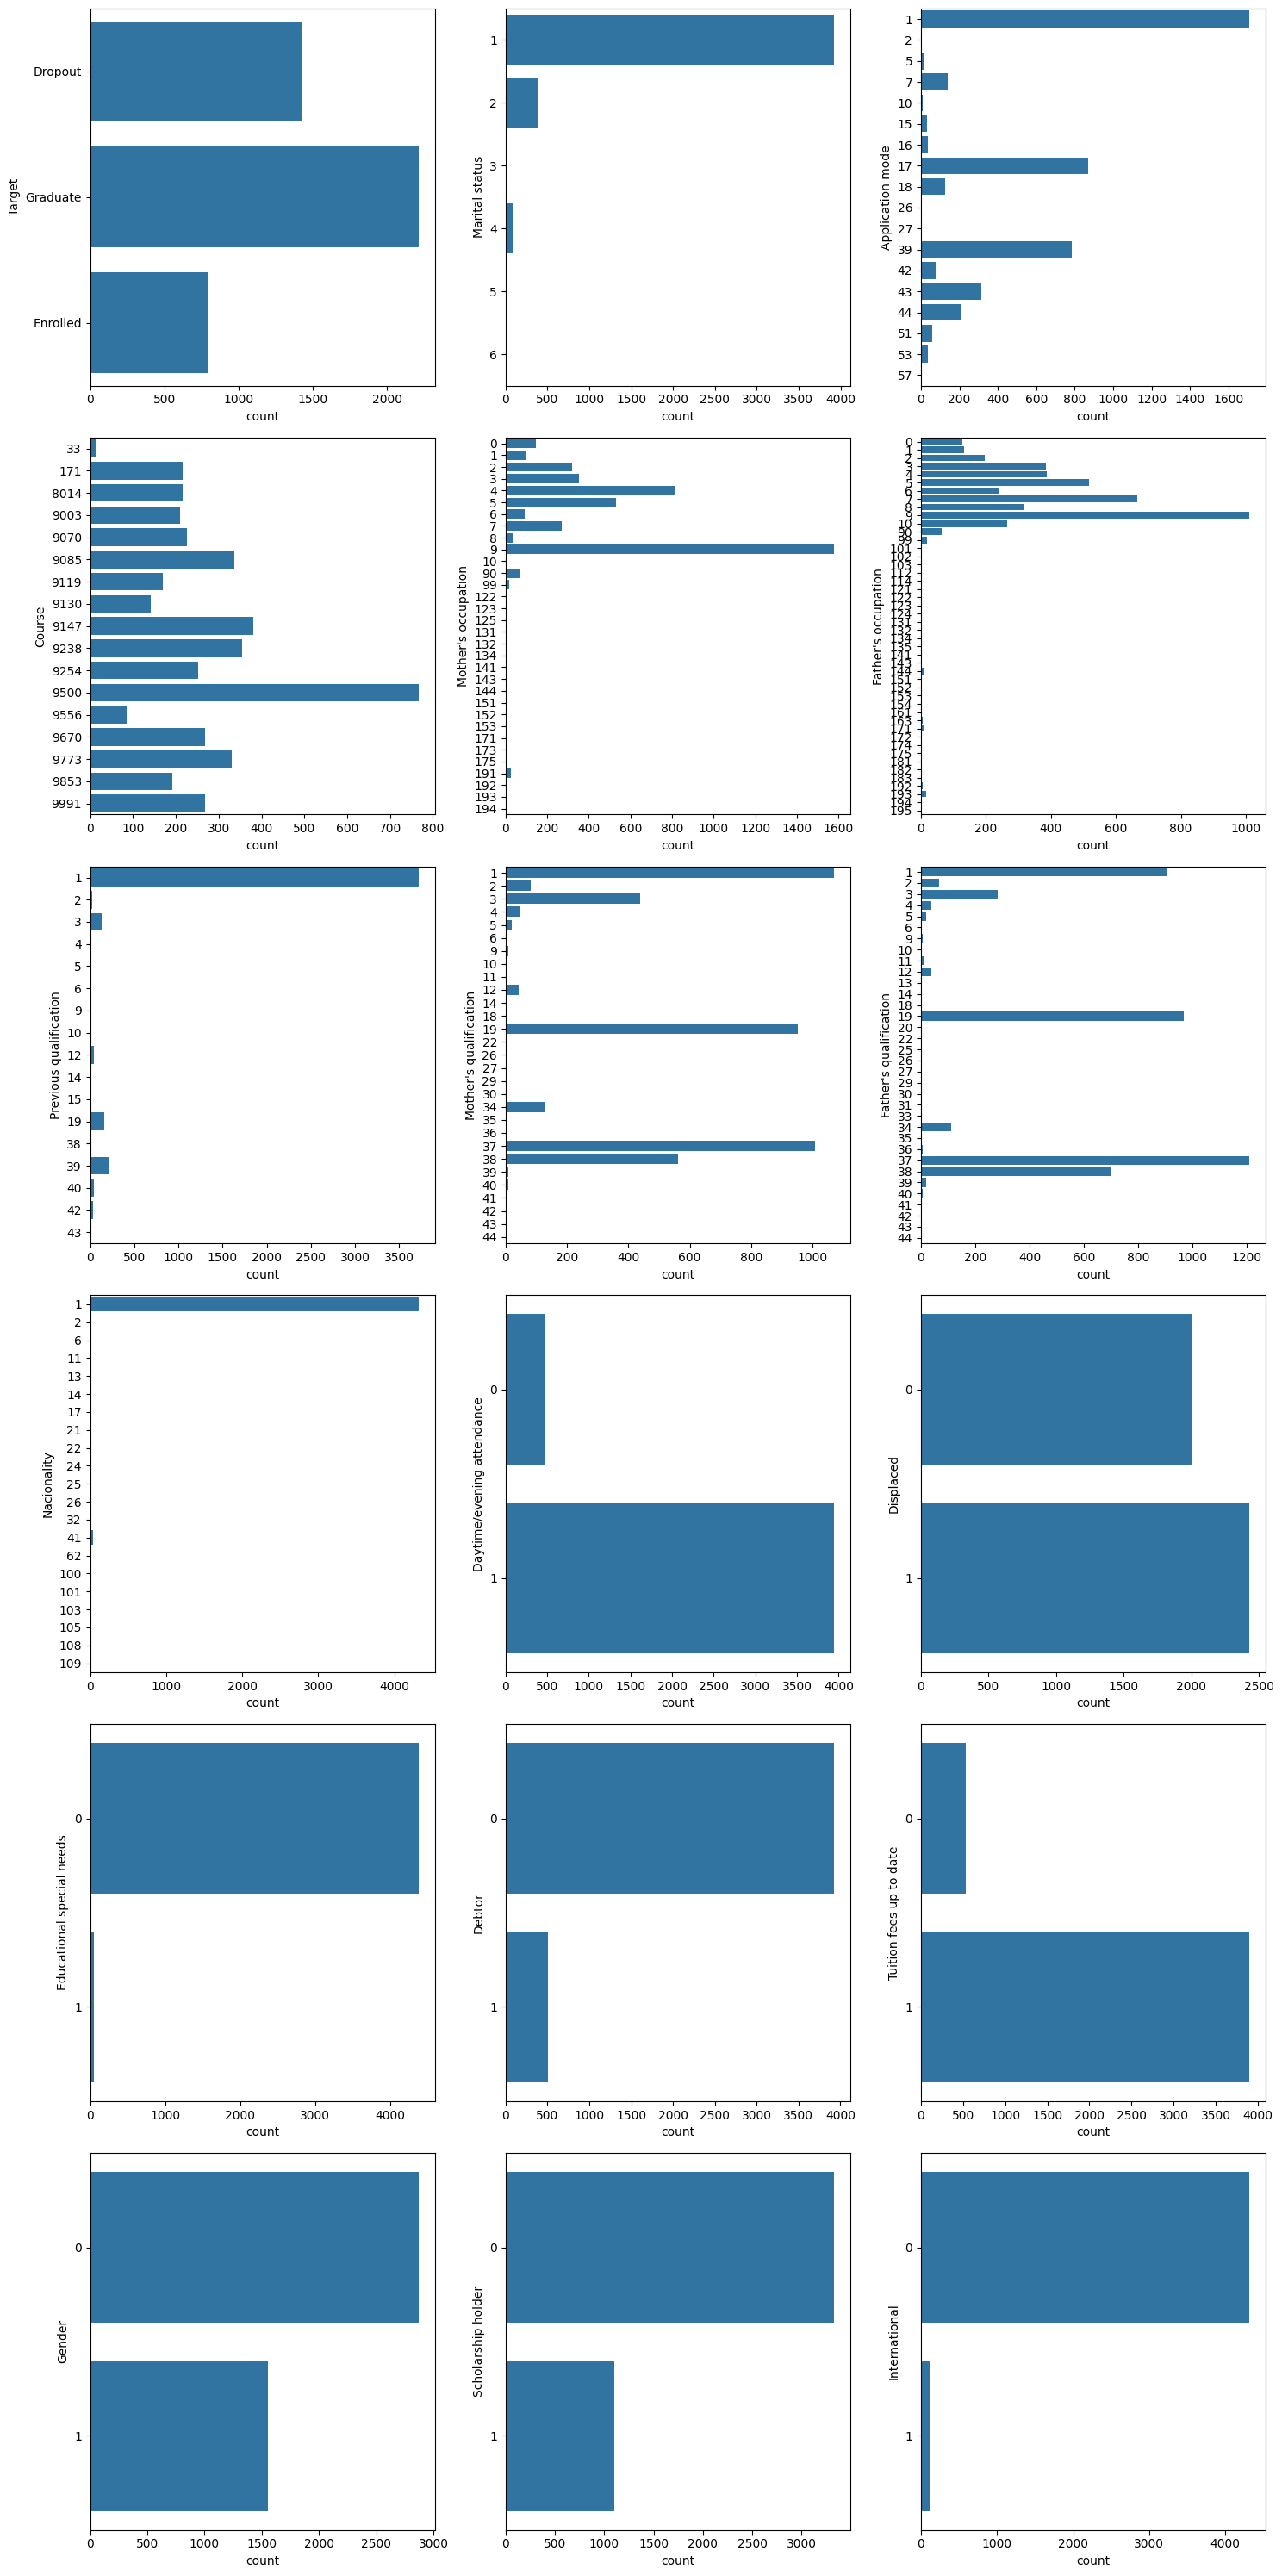

In [13]:
# Histograma variables categóricas

# Calculate number of rows needed for 3 columns
num_features = len([target_feature] + categorical_features + binary_features)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))  # Adjust figsize as needed

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate through features and plot
feature_index = 0
for feature in [target_feature] + categorical_features + binary_features:
    sns.countplot(y=feature, data=df, ax=axes[feature_index])  # Plot on the current subplot
    feature_index += 1

# Remove empty subplots if any
for i in range(feature_index, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Observando el histograma para la variable `Target` vemos que hay desequilibrio entre las clases, con una mayor cantidad de graduados, y menor de matriculados.

## 1.2. Selección de características

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

selection = False # True para realizar selección de características

selected_features = categorical_features + numerical_features + binary_features

if selection:
    # Definir variables predictoras y objetivo
    X = df.drop(columns=['Target']).copy()  # Reemplaza 'target' con el nombre de tu variable objetivo
    y = df['Target'].copy()

    # Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Estandarización de los datos (opcional, útil para algunos modelos)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Construir el modelo de Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Evaluar modelo
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Obtener la importancia de las características
    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    # Visualizar las características más importantes
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
    plt.xlabel("Importancia")
    plt.ylabel("Característica")
    plt.title("Importancia de las características en Random Forest")
    plt.gca().invert_yaxis()
    plt.show()

    # Selección de características más importantes (puedes ajustar el umbral)
    selected_features = feature_importances[feature_importances['importance'] > 0.015]['feature'].tolist()

print("Características seleccionadas:", selected_features)

Características seleccionadas: ['Marital status', 'Application mode', 'Course', "Mother's occupation", "Father's occupation", 'Previous qualification', "Mother's qualification", "Father's qualification", 'Nacionality', 'Application order', 'Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP', 'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Internat

In [15]:
# Filtramos las listas de features tras la seleccion

selected_features += ['Target'] # Añadimos el target

qualification_features = [feat for feat in selected_features if feat in qualification_features]
thresh_features = [feat for feat in selected_features if feat in thres_features]
categorical_features = [feat for feat in selected_features if feat in categorical_features]
numerical_features = [feat for feat in selected_features if feat in numerical_features]
binary_features = [feat for feat in selected_features if feat in binary_features]

### 1.3. Transformación de variables categóricas

En este apartado del preprocesamiento, aplicamos una serie de transformaciones a las variables categóricas del dataset, para facilitar la construcción del modelo. Algunas de estas variables contienen un gran número de categorías, por lo que para poder tratarlas de forma más eficiente, se van a agrupar dichas categorías en un menor número de categorías más generales.

En primer lugar, definimos una función `transformar_nivel_estudios`, que utilizamos para agrupar todas las categorías relacionadas con el nivel de estudios del estudiante y de sus padres en cuatro grupos más generales: "Incompleta", "Secundaria", "Superior Técnica" y "Universitaria".

In [16]:
def transformar_nivel_estudios(valor):
    """
    Transforma el nivel de estudios de un número entero a una de las cuatro nuevas categorías.
    """
    no_secundaria = {11, 26, 27, 38, 19, 12, 14, 15, 10, 9, 6, 29, 30, 35, 36, 37, 13, 20, 25}
    secundaria_completa = {1}
    superior_tecnico = {22, 39, 42, 18, 31, 33}
    superior_universitario = {2, 3, 4, 5, 40, 43, 44, 41}

    if valor in no_secundaria:
        return 0
    elif valor in secundaria_completa:
        return 1
    elif valor in superior_tecnico:
        return 2
    elif valor in superior_universitario:
        return 3
    else:
        return -1

niveles_estudios = {0: "Incompleta", 1: "Secundaria", 2: "Superior técnica", 3: "Universitaria", -1: "Otro"}

In [17]:
qualification_features = ['Previous qualification', 'Mother\'s qualification', 'Father\'s qualification']

for feature in qualification_features:
    df[feature] = df[feature].apply(transformar_nivel_estudios)

A continuación, como la variable `Nacionality` también contiene muchas categorías diferentes, y además la mayoría de ellas están representadas por un número muy reducido de instancias, hemos decidido cambiarla por una variable binaria llamada `foreign`. En esta nueva variable, 0 indica que el estudiante es de nacionalidad portuguesa y 1 que es extranjero.

In [18]:
# Transformar variables enteras a categóricas
df['Nacionality'] = df['Nacionality'].astype('category')
df['foreign'] = df['Nacionality'].map(lambda x: 0 if x == 1 else 1)

if 'Nacionality' in selected_features:
  selected_features.remove('Nacionality')
  selected_features += ['foreign']

  binary_features += ['foreign']
  categorical_features.remove('Nacionality')

df.drop(columns=['Nacionality'], inplace=True)

Para manejar aquellas categorías con baja frecuencia, en algunas columnas categóricas se ha usado un umbral del $5\%$ para agrupar las categorías con frecuencias muy bajas en una categoría general -1 (equivale a una clase ``otro''). Gracias a este paso, disminuimos el número de categorías en dichas variables.

In [19]:
# 5% threshold for categorical features

threshold = 0.05

for feature in thres_features:
    value_counts = df[feature].value_counts(normalize=True)
    if value_counts.max() > threshold:
        df[feature] = df[feature].apply(lambda x: x if value_counts[x] > threshold else -1) # -1 = other

Por último, creamos histogramas para observar la nueva distribución de las variables categóricas tras haber realizado las transformaciones.

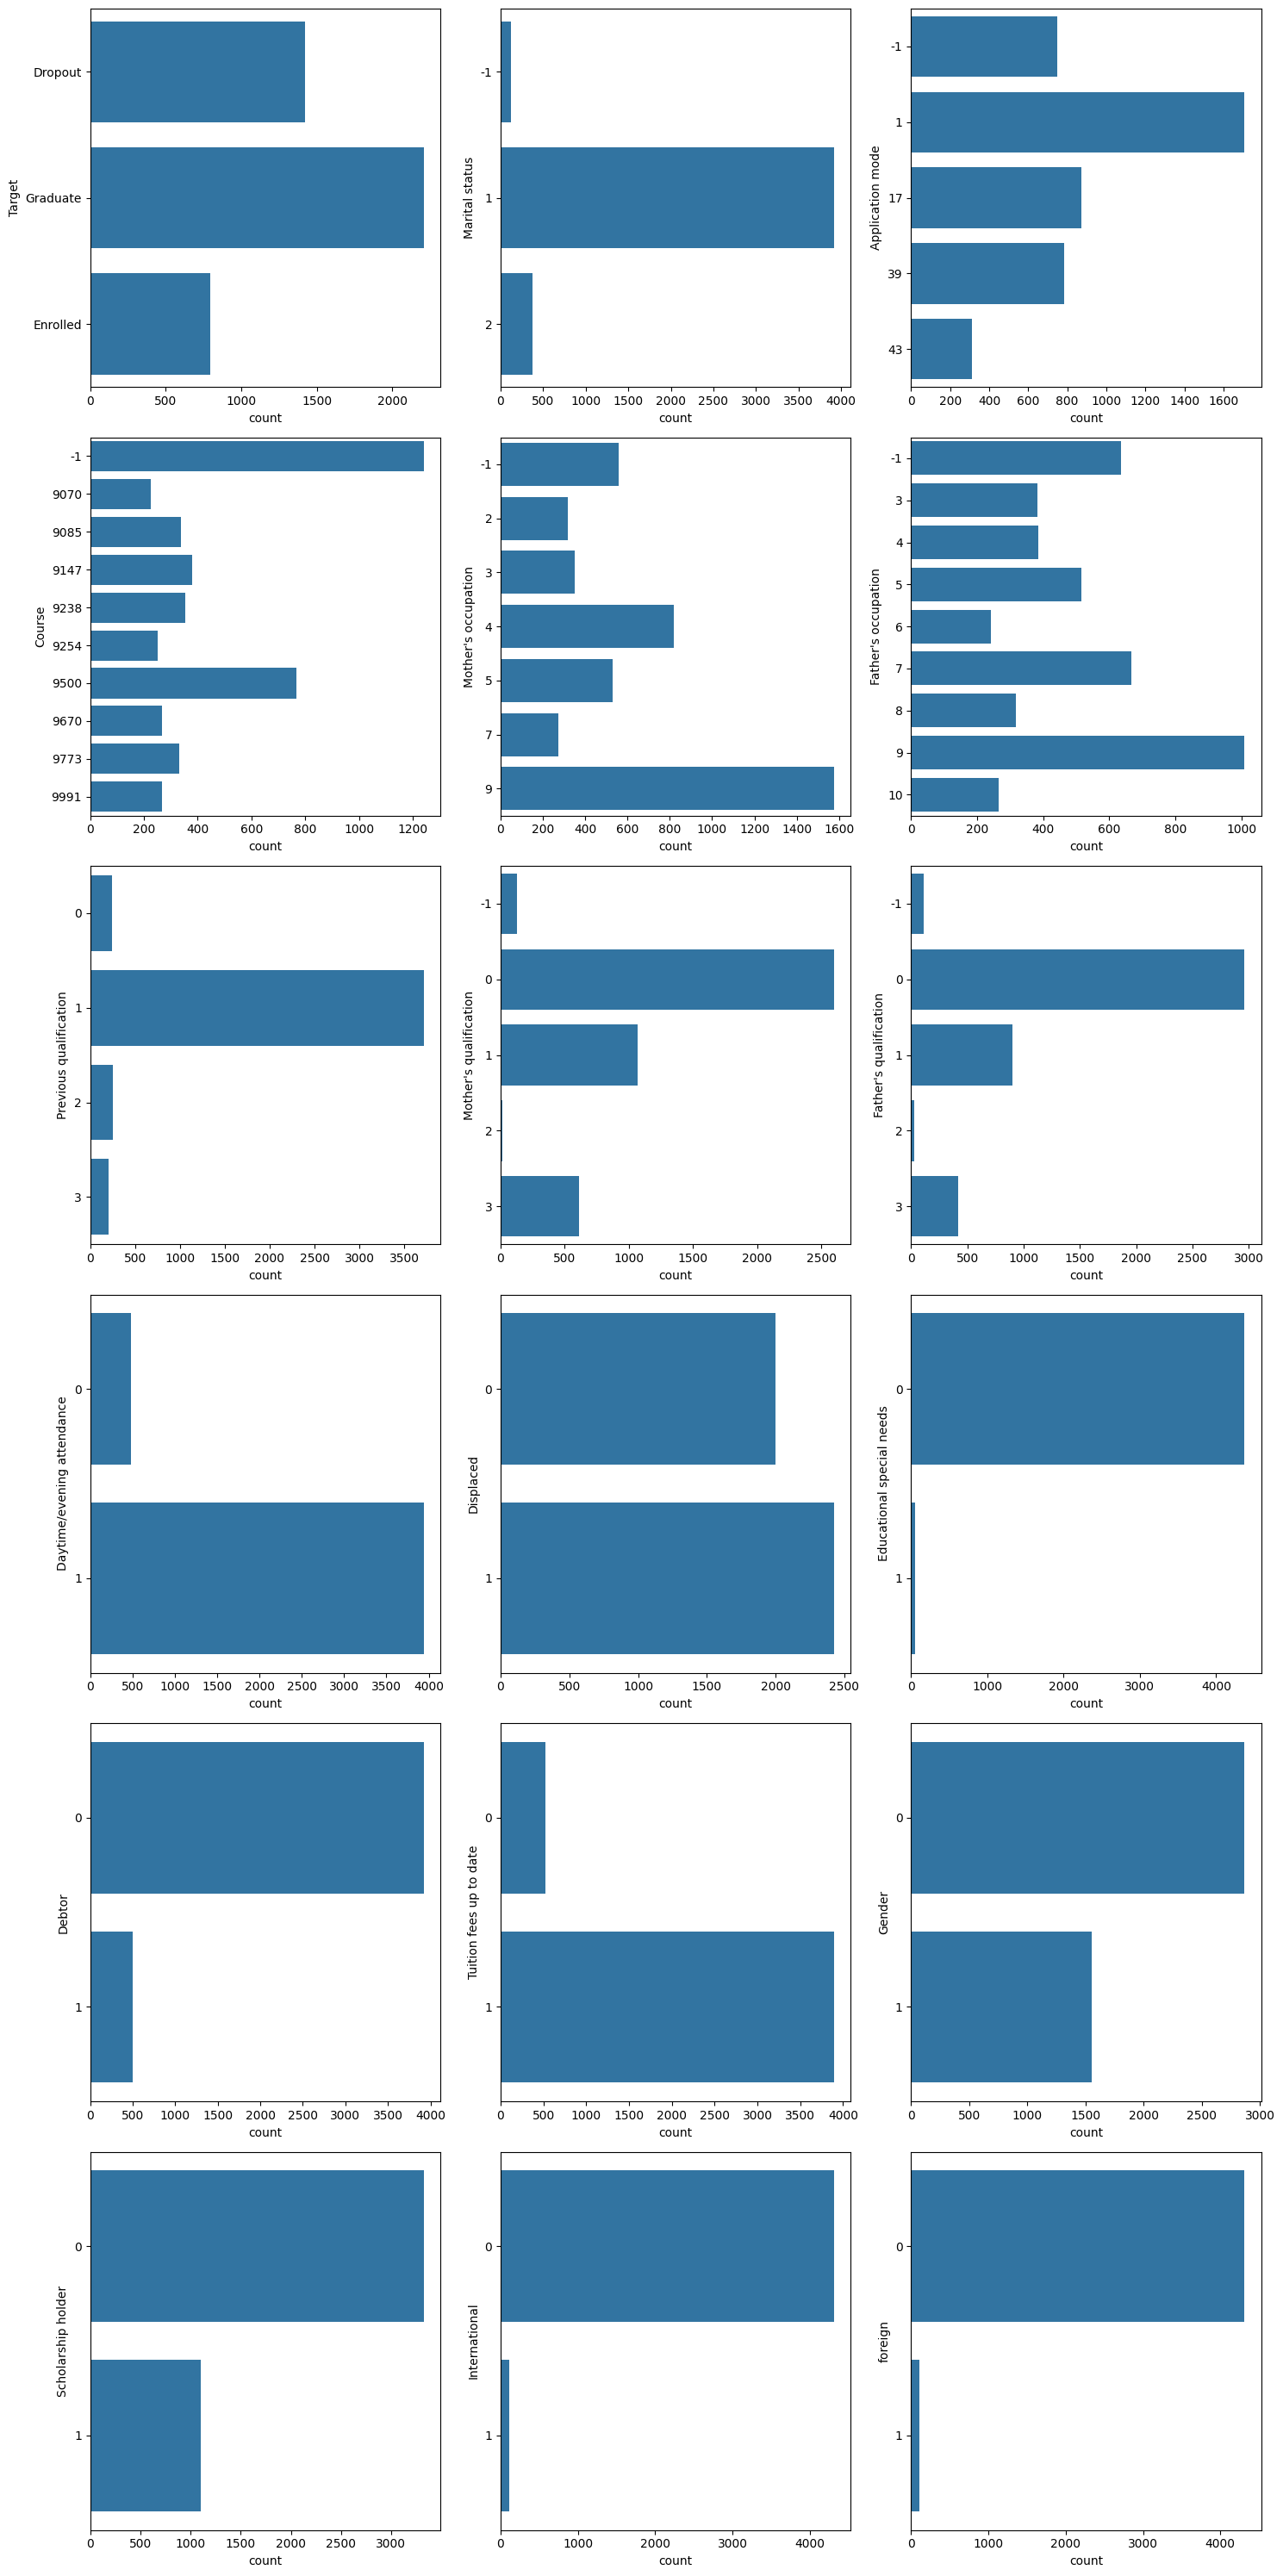

In [20]:
# Histograma variables categóricas

# Calculate number of rows needed for 3 columns
num_features = len([target_feature] + categorical_features + binary_features)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))  # Adjust figsize as needed

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate through features and plot
feature_index = 0
for feature in [target_feature] + categorical_features + binary_features:
    sns.countplot(y=feature, data=df, ax=axes[feature_index])  # Plot on the current subplot
    feature_index += 1

# Remove empty subplots if any
for i in range(feature_index, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Ahora, se convierten las variables categóricas a tipo `category`.

In [21]:
for feature in categorical_features:
    df[feature] = df[feature].astype('category') # other

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  4424 non-null   category
 1   Application mode                                4424 non-null   category
 2   Application order                               4424 non-null   int64   
 3   Course                                          4424 non-null   category
 4   Daytime/evening attendance                      4424 non-null   int64   
 5   Previous qualification                          4424 non-null   category
 6   Previous qualification (grade)                  4424 non-null   float64 
 7   Mother's qualification                          4424 non-null   category
 8   Father's qualification                          4424 non-null   category
 9   Mother's occupation           

### 1.3. Variables numéricas

A continuación, visualizamos las distribuciones de las variables numéricas utilizando histogramas y curvas de densidad.

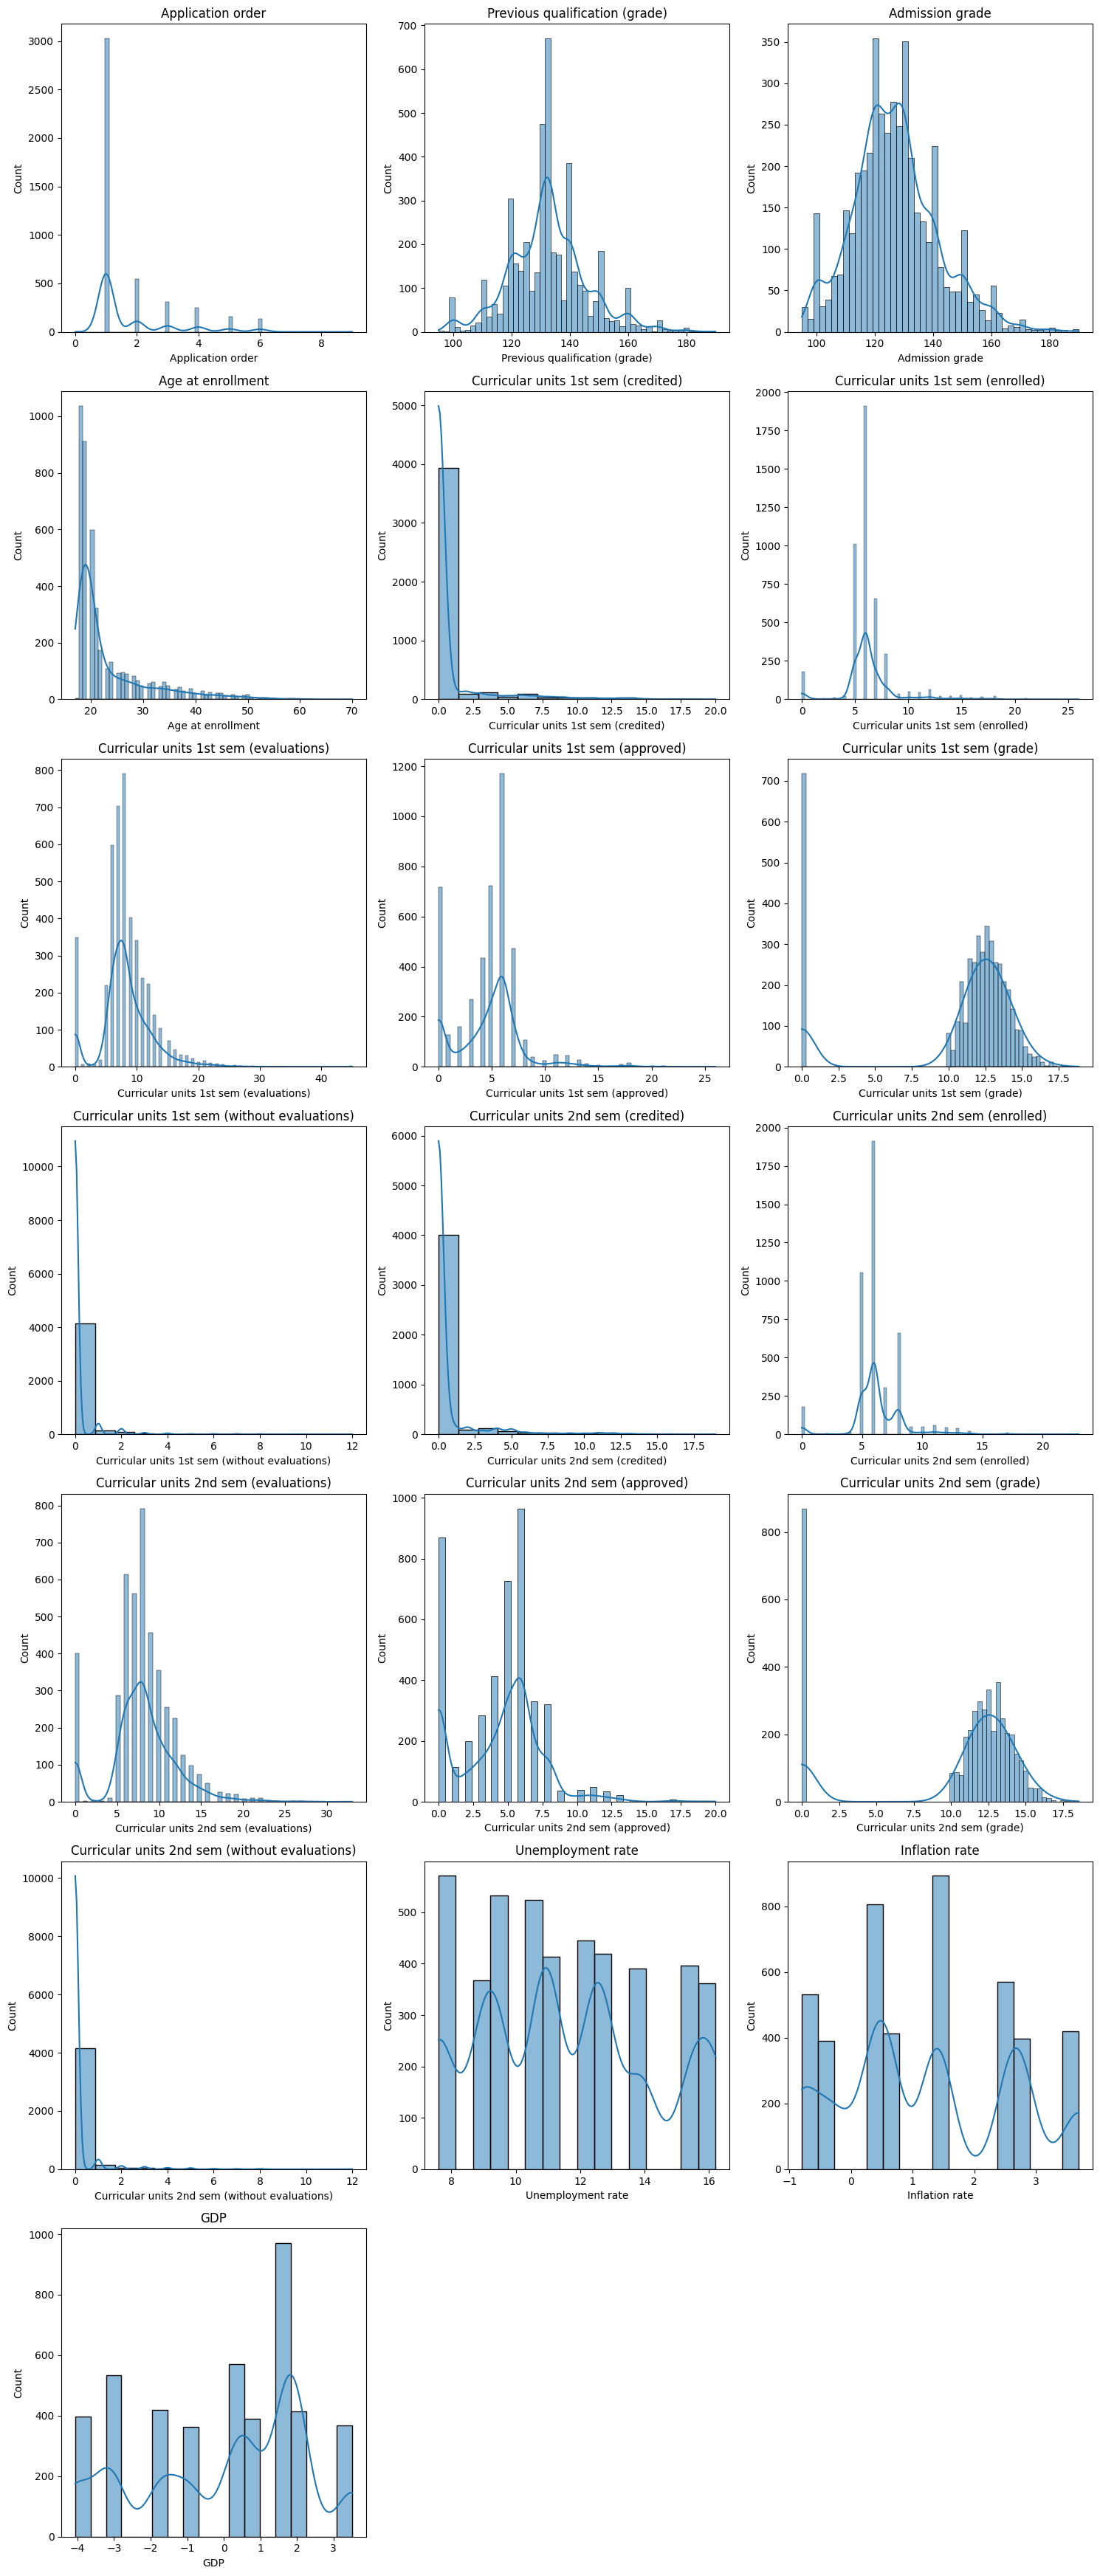

In [23]:
# Lista de características numéricas

# Definir el número de columnas y calcular el número de filas
num_cols = 3
num_rows = math.ceil(len(numerical_features) / num_cols)

# Crear la figura y los ejes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Aplanar para facilitar la iteración

# Graficar cada característica
for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], kde=True, ax=axes[i])
    axes[i].set_title(feature)

# Eliminar ejes vacíos si hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 1.4. Partición de los datos en *Train* y *Test*

Particionamos los datos en un conjunto de *train* del $90\%$ que usaremos para entrenar el modelo, y un conjunto de *test* del $10\%$ que usaremos para evaluar el modelo ya entrenado, comprobando su capacidad de generalización a nuevos datos, y evaluando que no haya overfitting.

In [24]:
df_raw = df.copy()
df = df[selected_features]

In [25]:
# Definir el mapeo
target_mapping = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}              # Reemplaza con los valores reales
inverse_target_mapping = {v: k for k, v in target_mapping.items()}    # Crea el mapeo inverso

# Aplicar el mapeo a la columna 'Target'
df['Target'] = df['Target'].map(target_mapping)

# Verificar el resultado
print(df['Target'].value_counts())  # Ver distribución de clases

Target
2    2209
0    1421
1     794
Name: count, dtype: int64


In [26]:
X = df.drop(columns=['Target'])
y = df['Target']
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=SEED)

### TODO: Outliers

In [27]:
outliers = False

if outliers:
  # Creamos un DataFrame con las puntuaciones promediadas
  features_df = pd.DataFrame({
      "Feature": X.columns,
      "Score": selector.scores_
  }).sort_values(by="Score", ascending=False)

  print(features_df)

  # Filtramos por umbral
  threshold = 5  # Puntuación mínima aceptable
  selected_features = features_df[features_df["Score"] > threshold]["Feature"]

  # Creamos nuevos conjuntos de datos con las características seleccionadas
  X_train = X_train[selected_features]
  X_test = X_test[selected_features]

## 2. Entrenamiento del modelo (XGBoost)


En este apartado, entrenamos un modelo de árbol de decisión utilizando un *Pipeline* que incorpora tanto un procesamiento de las variables como la búsqueda de los mejores hiperparámetros mediante *Grid Search*.

El preprocesamiento que se aplica a las variables depende del tipo. A las variables categóricas se les aplica *One Hot Encoding*, convirtiéndolas en columnas binarias que representan las características de cada variable. Por otro lado, a las características binarias se les aplica un `FunctionTransformer` para asegurar que los datos sean procesados correctamente en el *Pipeline*.

In [28]:
# Preprocesamiento por tipo de variable
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaler', StandardScaler(), numerical_features),
    ('binary', FunctionTransformer(lambda x: x if x.ndim > 1 else x[:, None]), binary_features)
])

xgb = XGBClassifier(random_state=SEED, n_jobs=-1)

# Pipeline completo
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

In [29]:
# Ejecutamos un Grid search y nos quedamos con el modelo de mejores hiperparámetros

param_grid = {
    'classifier__n_estimators': Integer(50, 300),
    'classifier__grow_policy': Categorical(['lossguide']),
    'classifier__max_depth': Integer(5, 15),
    'classifier__learning_rate': Real(0.01, 0.1, prior='uniform'),
    'classifier__subsample': Real(0.6, 1, prior='uniform'),
    'classifier__colsample_bytree': Real(0.6, 1, prior='uniform'),
    'classifier__reg_alpha': Real(0.1, 0.5, prior='uniform'),
    'classifier__reg_lambda': Real(0.1, 0.5, prior='uniform')
}

if not LOAD:
    grid_search = BayesSearchCV(model, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, random_state=SEED, n_iter=150)
    grid_search.fit(X_train, y_train)
    print("Mejores parámetros:", grid_search.best_params_)


best_model = grid_search.best_estimator_ if not LOAD else load_model(model_path)

In [30]:
if not LOAD:
    save_model(best_model, model_path=model_path)  # Guarda el modelo

In [31]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Marital status',
                                                   'Application mode', 'Course',
                                                   "Mother's occupation",
                                                   "Father's occupation",
                                                   'Previous qualification',
                                                   "Mother's qualification",
                                                   "Father's qualification"]),
                                                 ('scaler', StandardScaler(),
                                                  ['Application order',
                                                   'Previous qualification '
                                                   '(grade)',...
                               grow_policy='lossguide', importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.04798741738917225, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=12,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=203, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [32]:
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')

print("F1-score en test:", f1)
print("Mejores parámetros:", best_model.get_params())

F1-score en test: 0.7570681273978376
Mejores parámetros: {'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Marital status', 'Application mode',
                                  'Course', "Mother's occupation",
                                  "Father's occupation",
                                  'Previous qualification',
                                  "Mother's qualification",
                                  "Father's qualification"]),
                                ('scaler', StandardScaler(),
                                 ['Application order',
                                  'Previous qualification (grade)',
                                  'Admission grade', 'Age at enrollment'...
                                  'Curricular units 2nd sem (approved)',
                                  'Curricular units 2nd sem (grade)',
                                  'Cur

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78       142
           1       0.52      0.44      0.48        80
           2       0.81      0.88      0.84       221

    accuracy                           0.76       443
   macro avg       0.71      0.69      0.70       443
weighted avg       0.75      0.76      0.76       443



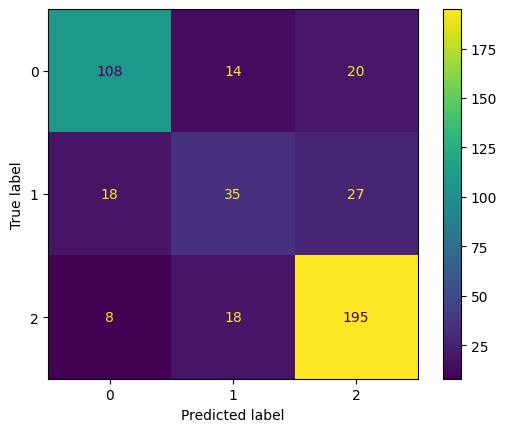

In [34]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.show()

## 3. Explicación del modelo (TODO: BORRAR SI SE EXPLICA EL PIPELINE COMPLETO)

A continuación haremos una explicadión del clasificador (último paso del pipeline que recibe las variables transformadas) a partir de SHAP.

In [35]:
# Obtener el modelo XGBoost dentro del Pipeline
xgb_model = best_model.named_steps['classifier']

# Tomar un subconjunto de datos transformados
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

# Crear el TreeExplainer directamente con el modelo XGBoost
sample_size = 100
X_transformed_sub = shap.sample(X_train_transformed, sample_size)
explainer = shap.TreeExplainer(xgb_model, X_transformed_sub)

# Obtener valores SHAP para los datos transformados
shap_values = explainer.shap_values(X_test_transformed)

100%|===================| 1328/1329 [02:48<00:00]        

In [36]:
categorical_features_transformed = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names_trans = list(categorical_features_transformed) + list(numerical_features) + list(binary_features)
target_names = ['Dropout', 'Graduate', 'Enrolled']

# Crear la explicación de SHAP
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value[1],  # Selecciona la misma clase que arriba
    data=X_test_transformed,
    feature_names=feature_names_trans
)

### Global bar plots

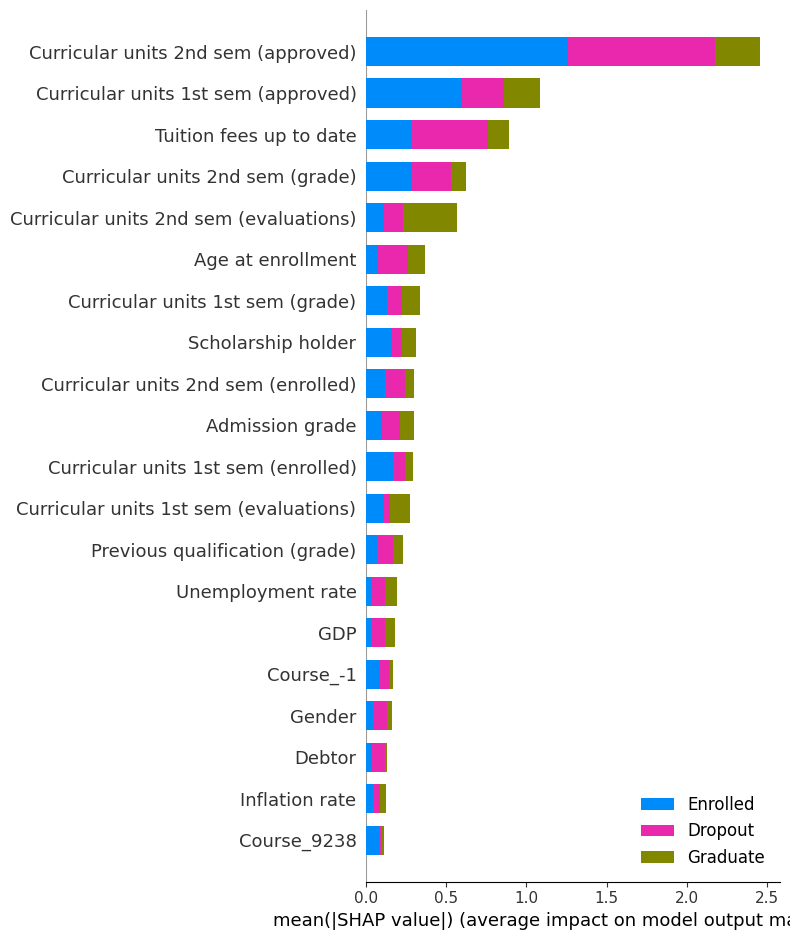

In [37]:
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names_trans, class_names=target_names, plot_type='bar')

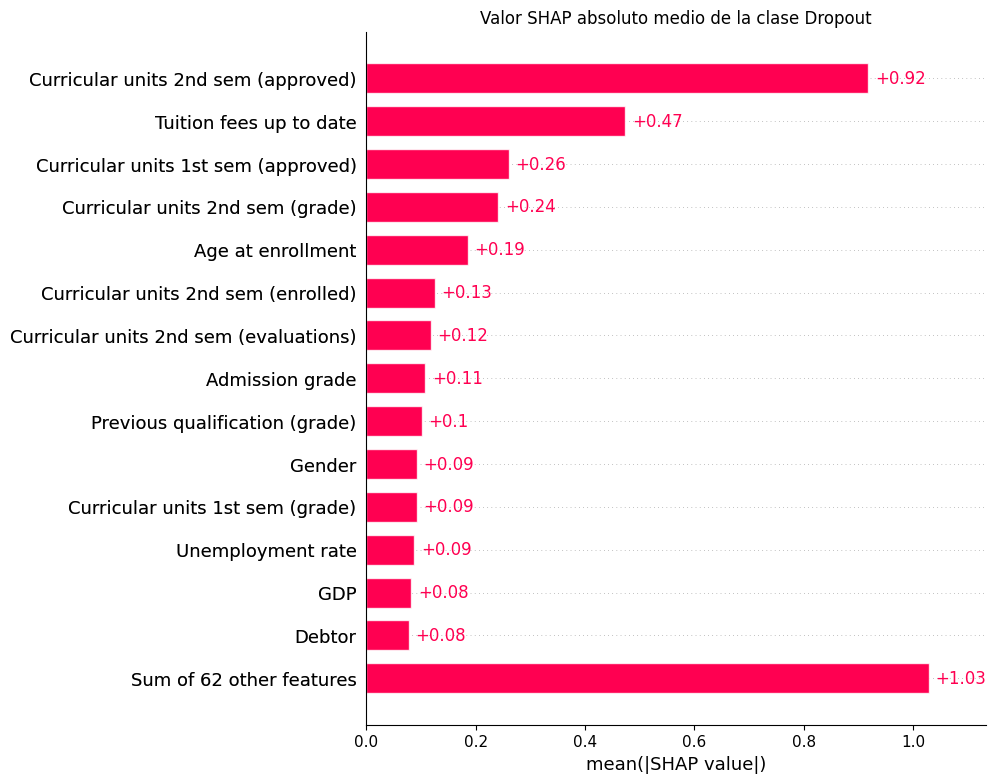

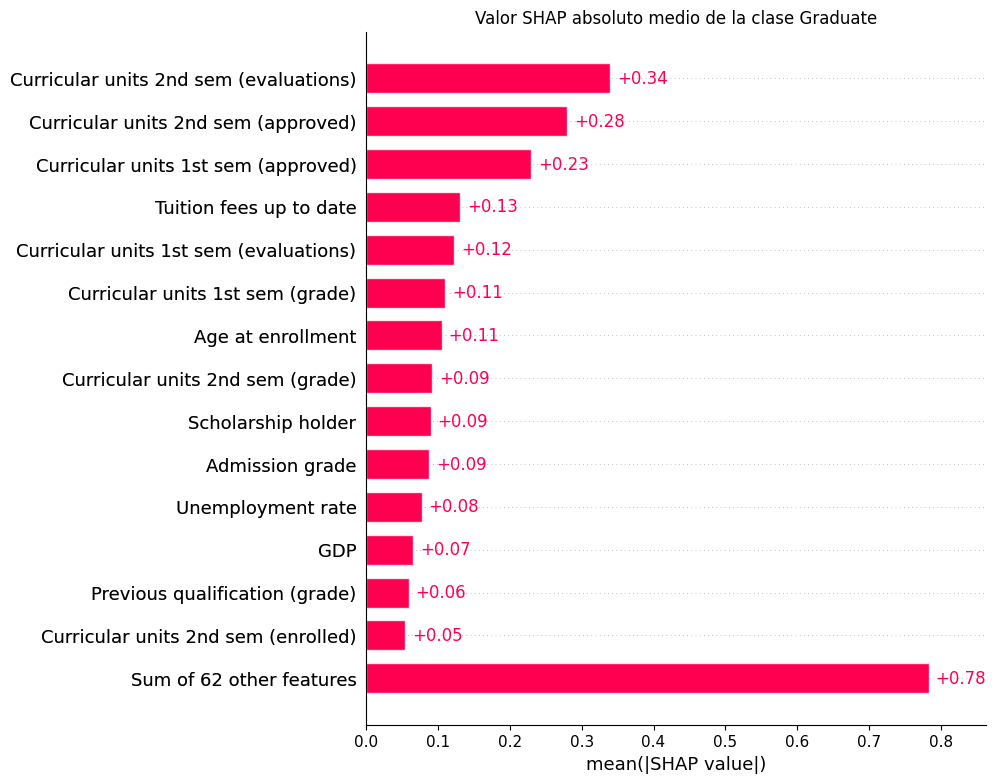

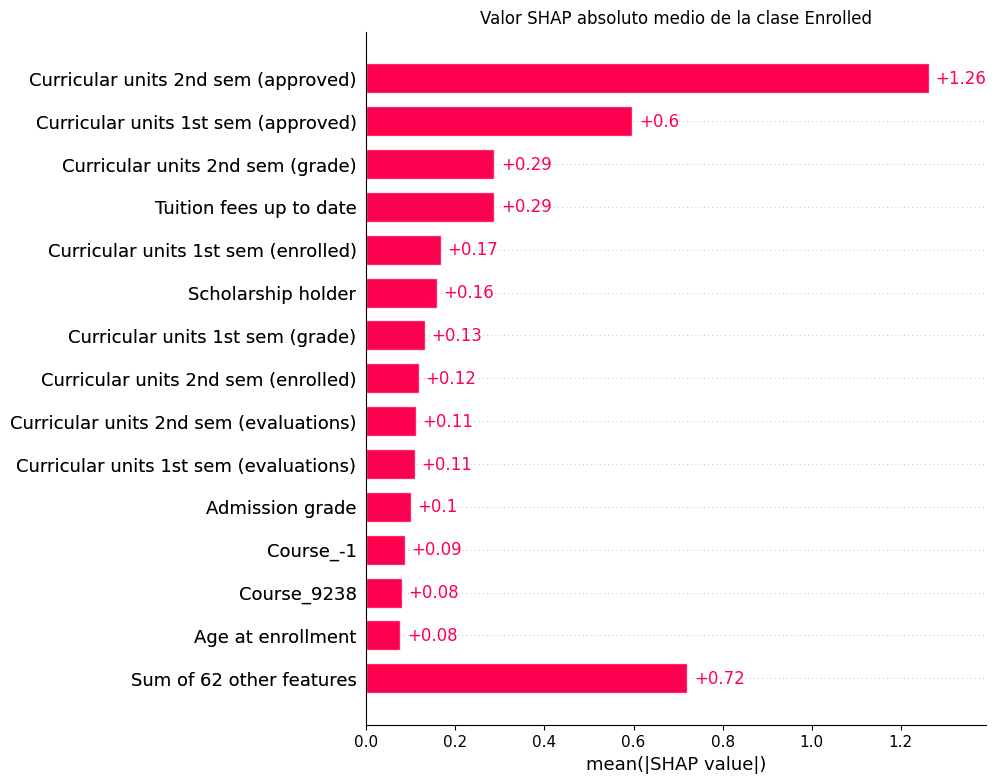

In [38]:
for i, name in enumerate(target_names):
    shap.plots.bar(shap_explanation[:, :, i], max_display = 15, show = False)
    plt.title(f"Valor SHAP absoluto medio de la clase {name}")
    plt.show()

### Beeswarm plot

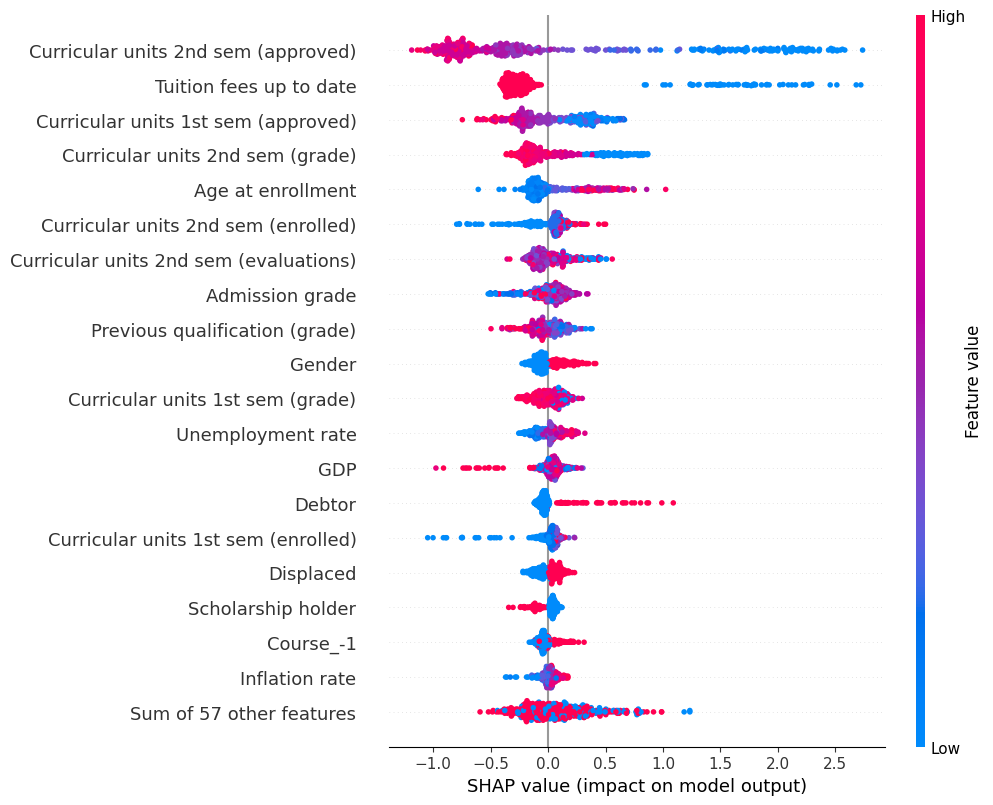

In [39]:
# Graficar el beeswarm plot
shap.plots.beeswarm(shap_explanation[:, :, 0], max_display=20)

### SHAP para instancias seleccionadas

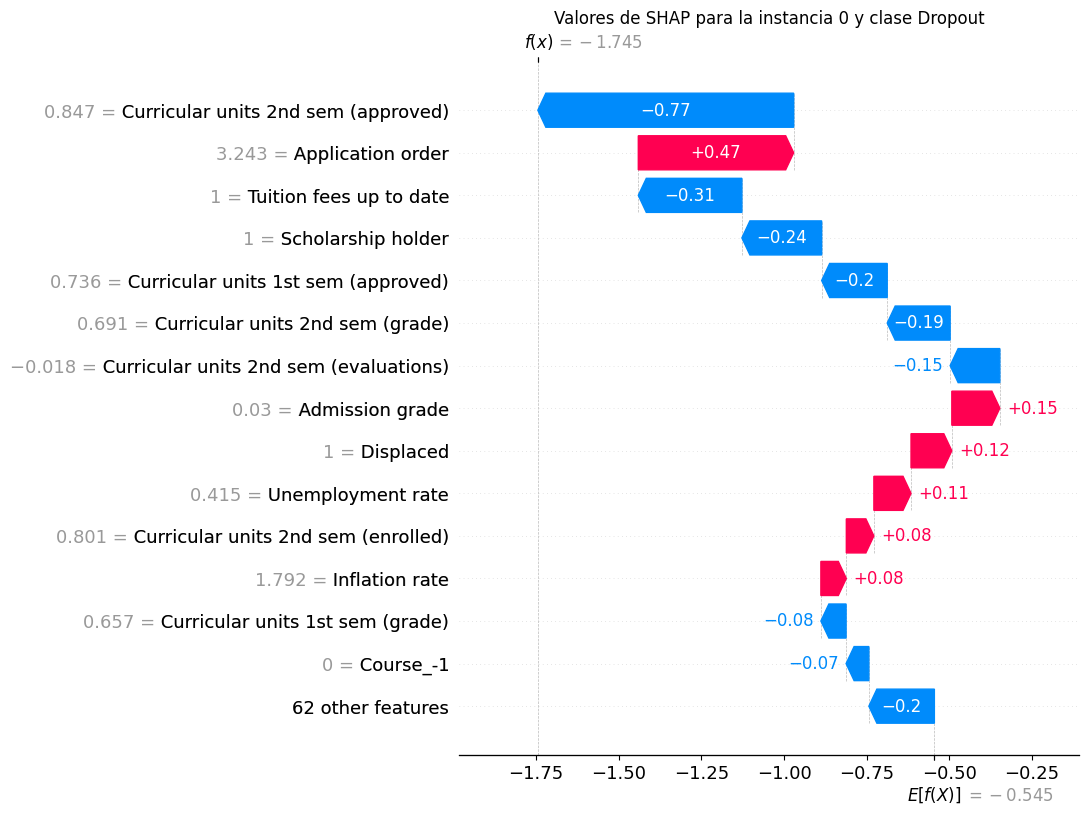

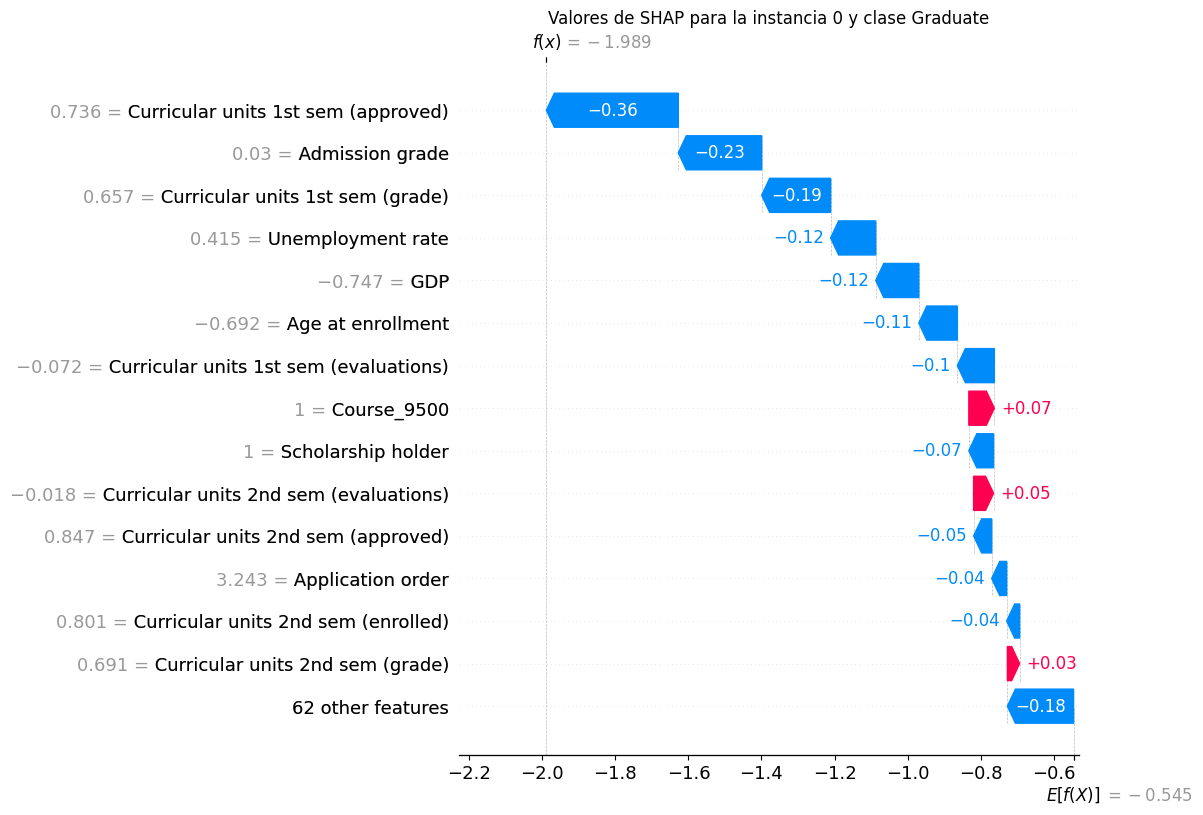

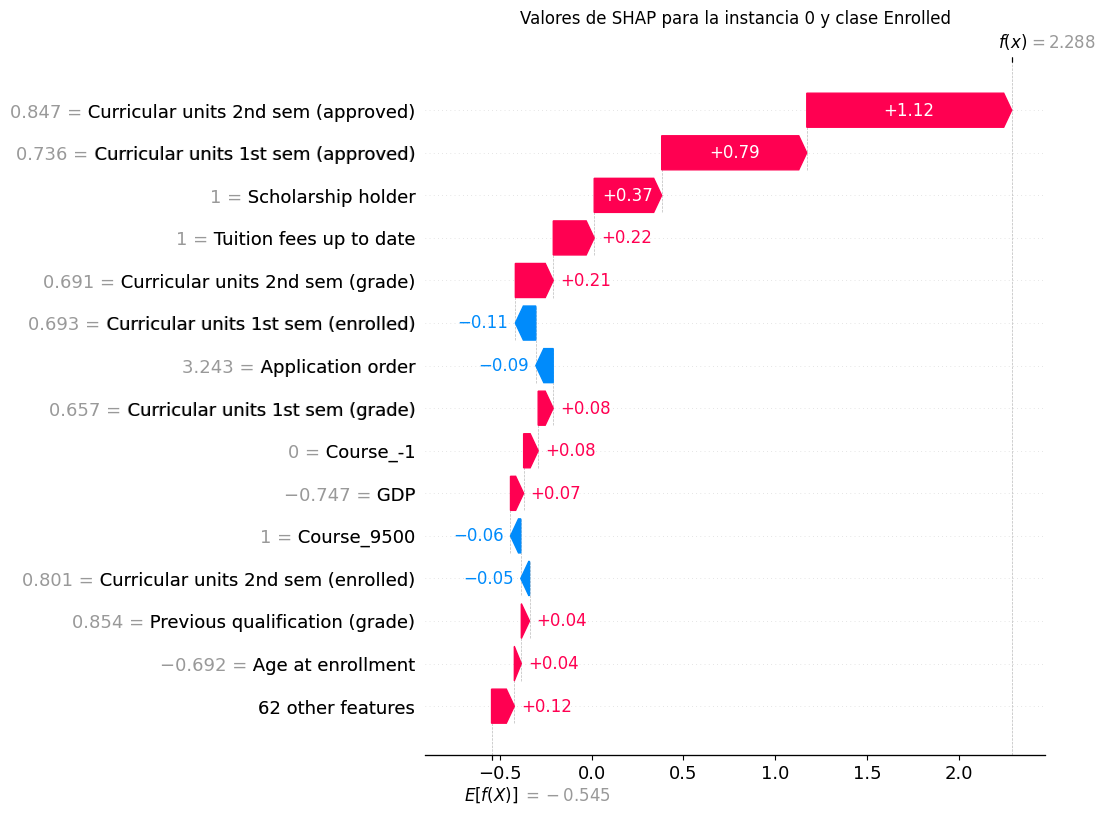

In [40]:
# TODO: Seleccionar instancias. Mostramos la instancia 0
data_indexes = [0]
class_index = 1
for data_index in data_indexes:
    for class_index, name in enumerate(target_names):
        shap.plots.waterfall(shap_explanation[data_index,:,class_index], max_display=15, show=False)
        plt.title(f"Valores de SHAP para la instancia {data_index} y clase {name}")
        plt.show()

## Explicación del modelo (pipeline)

A continuación haremos una explicación del modelo de clasificación a partir de los valores SHAP obtenidos utilizando la librería _shap_. Para obtener los valores SHAP utilizamos un explicador agnóstico del modelo, concretamente _PermutationExplainer_ya que nuestro modelo se ha implementado con un _Pipeline_ de _sklearn_. De esta forma se obtienen los valores SHAP para las características sin transformar que recibe el modelo. Al ser un problema de clasificación en 3 clases objetivo, hay un valor SHAP por cada instancia, característica **y además por cada clase**. 

Para generar el explicador, utilizamos una muestra del conjunto de entrenamiento. Obtendremos los valores SHAP del conjunto de test, y haremos una explicación global del modelo a partir de ellos, y después haremos explicaciones locales de un subconjunto de instancias interesante y representativo del dataset de entrenamiento y test.

In [41]:
# Crear el TreeExplainer directamente con el modelo XGBoost
sample_size = 1000
X_sub = shap.sample(X_train, sample_size)
explainer = shap.Explainer(best_model.predict_proba, X_sub)

# Obtener valores SHAP para los datos transformados
shap_values = explainer.shap_values(X_test)

PermutationExplainer explainer: 444it [01:24,  4.82it/s]                         


### Global bar plots

En el siguiente gráfico de barras vemos, para cada característica, el valor de SHAP absoluto medio por cada clase objetivo. El color indica la clase objetivo: Enrolled (azul), Dropout (rosa) y Graduate (verde). Las variables aparecen ordenadas de arriba abajo de mayor a menor suma del valor absoluto SHAP promedio para las 3 clases objetivo (longitud de la barra). 

En una instancia dada, el valor SHAP de una característica y clase es una medida de la contribución del valor de dicha característica a que la predicción sea esa clase (valor SHAP positivo) o no lo sea (valor SHAP negativo). Así, el valor absoluto medio del valor SHAP de una característica y una clase es un indicador de la contribución media (global) de la característica para la predicción de esa clase, y la suma de los valores absolutos medios de cada clase es una medida de la contribución global de cada variable al modelo de clasificación. En definitiva, una mayor longitud de la barra indica una mayor contribución de la variable en nuestro modelo. Interpretando el gráfico obtenemos las siguientes conclusiones:

- La variable Curricular units 2nd sem (approved) tiene un valor SHAP promedio notablemente mayor que el resto, lo que indica que es la variable más importante para la clasificación.

- Le siguen Tuition fees up to date y Curricular units 1st sem.

- Observamos un punto de silla en la suma de los valores SHAP promedio a partir de Age at enrollment a partir del cual las variables tienen progresivamente menor valor SHAP promedio. 

/tmp/ipykernel_10201/4106938762.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, class_names=target_names, plot_type='bar')


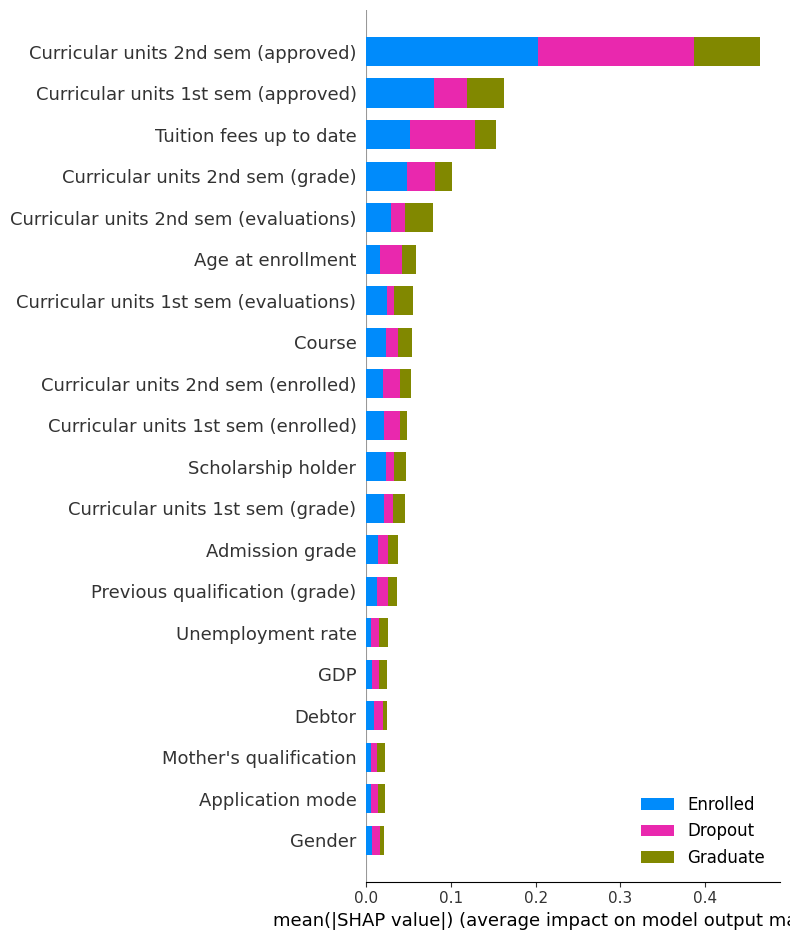

In [42]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, class_names=target_names, plot_type='bar')

A continuación mostramos un gráfico de barras con el valor SHAP absoluto medio de cada clase objetivo. Esta es una medida de la contribución global de cada variable a la distinción de cada una de las clases objetivo por parte del clasificador, y podemos comparar las similitudes y diferencias entre clases.

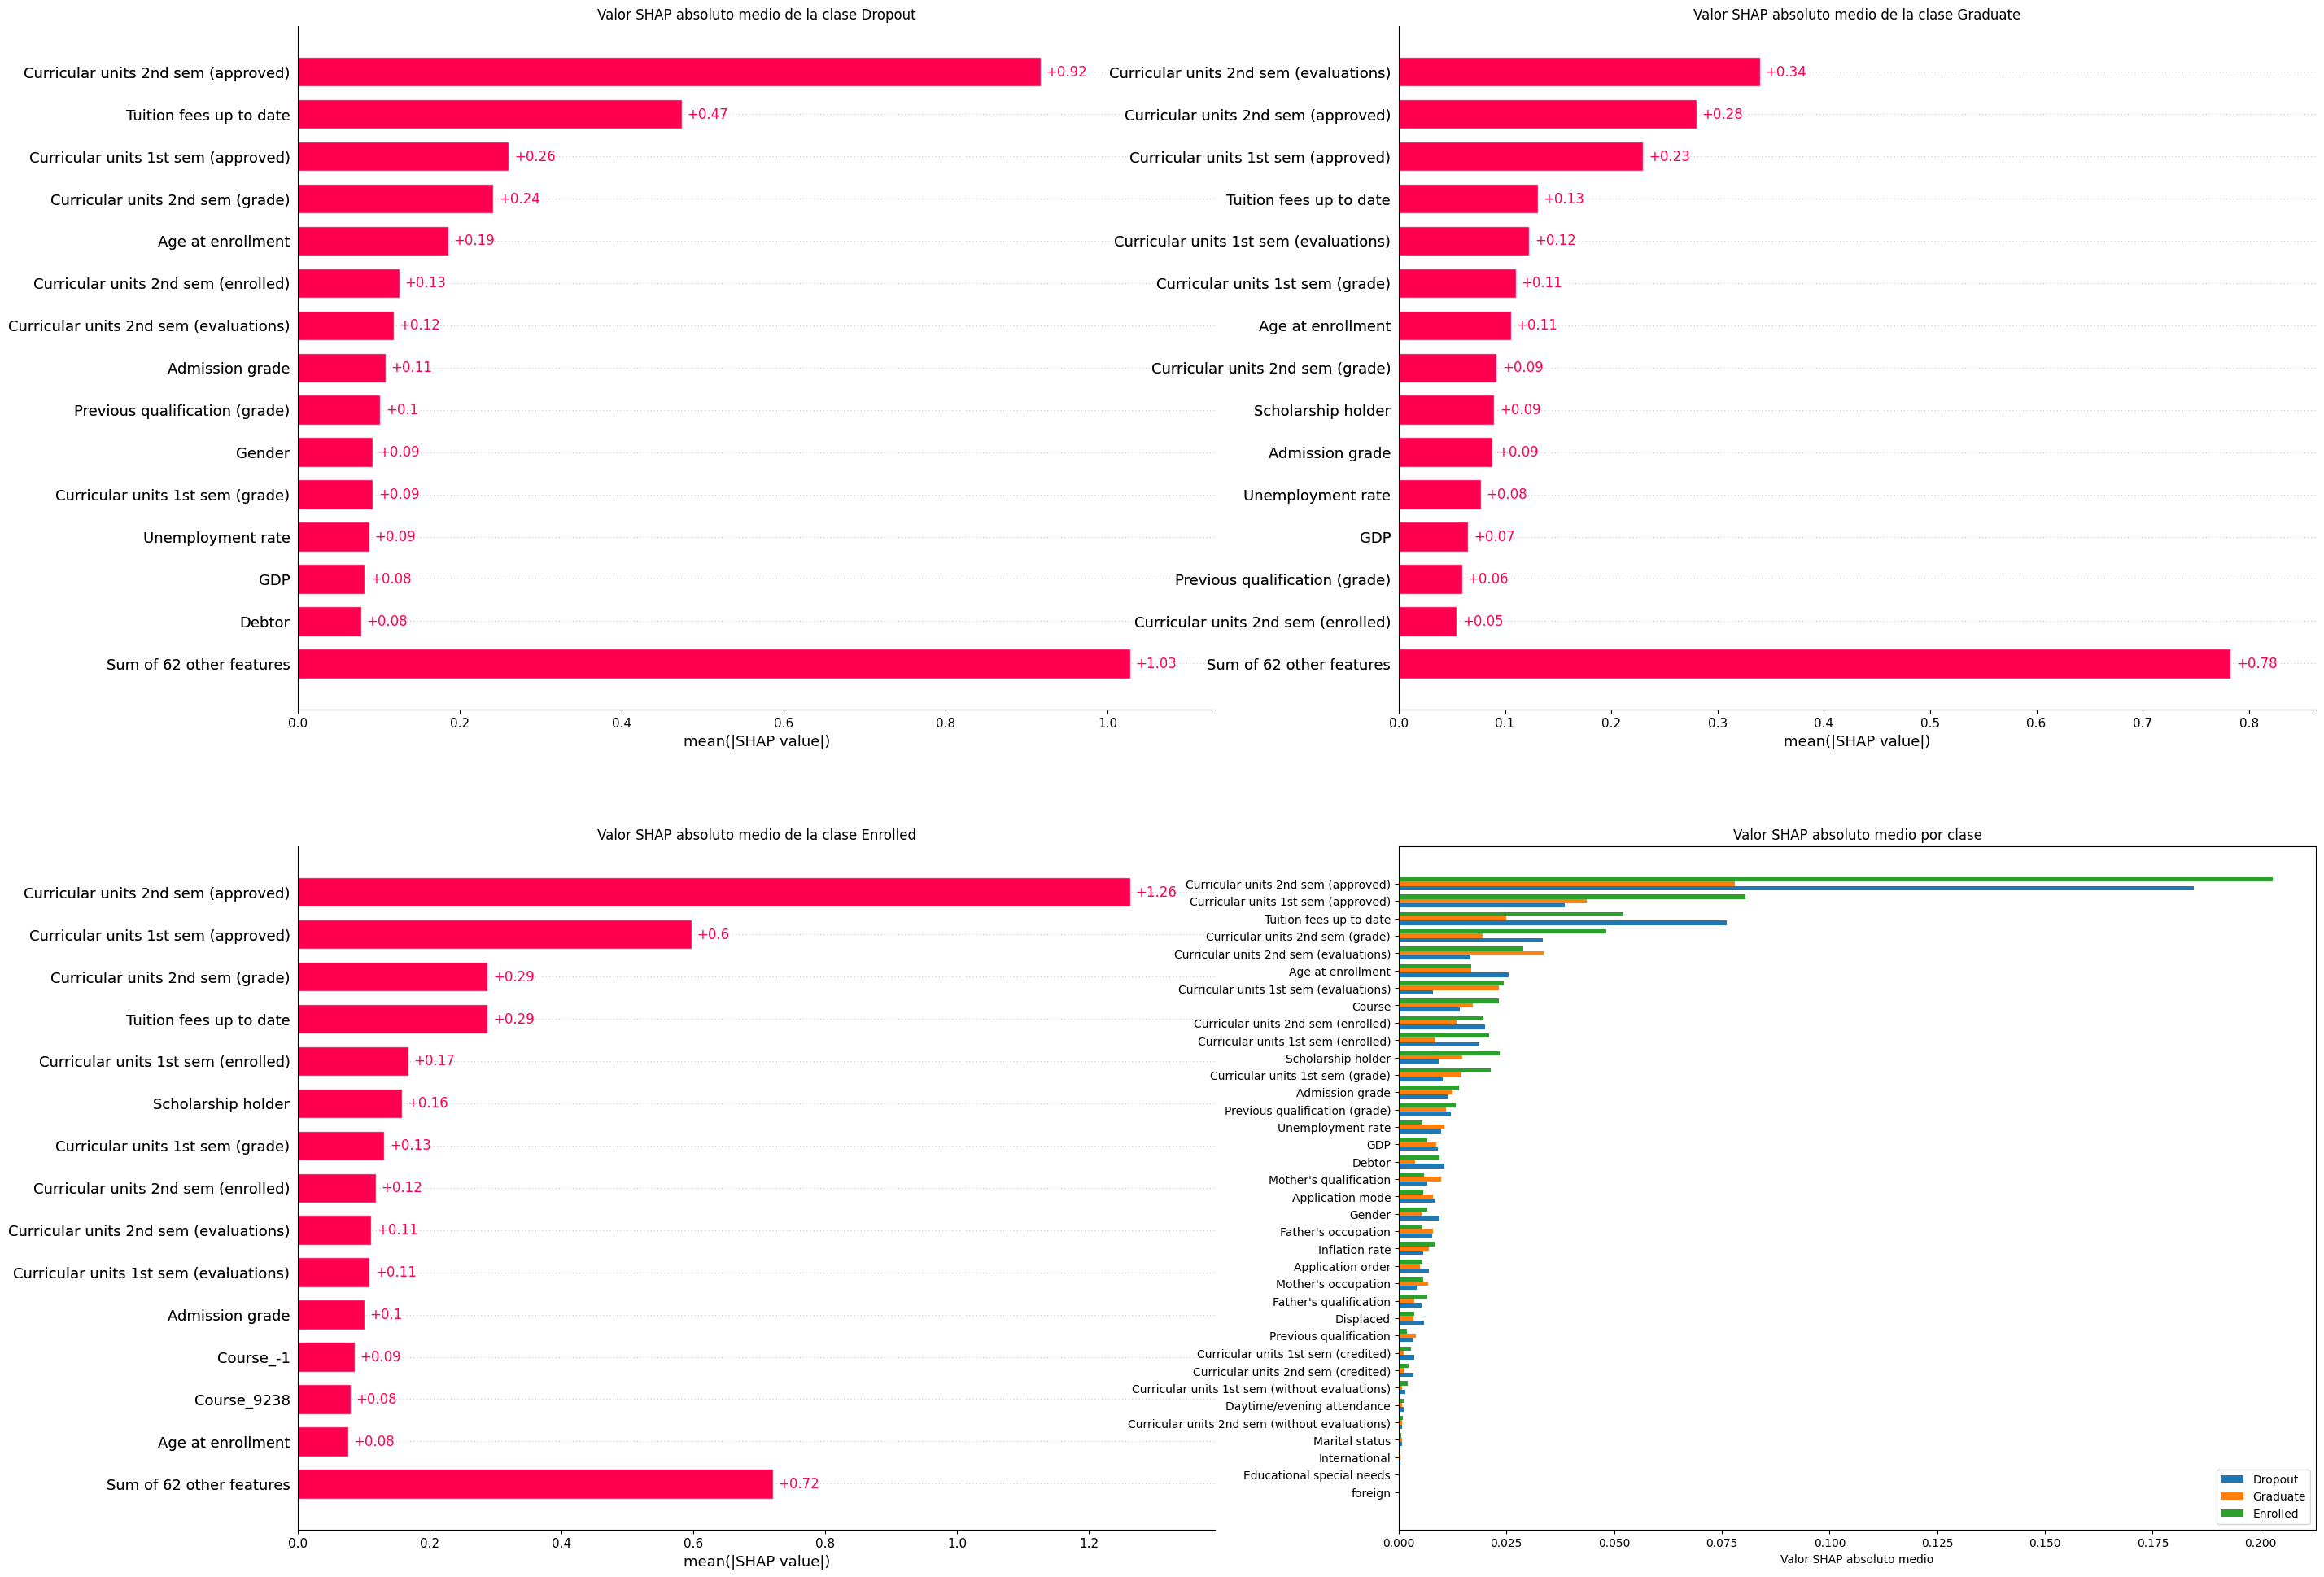

In [43]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(32, 24))
for i, name in enumerate(target_names):
    ax = axes[i//2, i%2]
    plt.sca(ax)  # Asegura que los gráficos se dibujen en el eje correcto
    shap.plots.bar(shap_explanation[:, :, i], max_display = 15, show = False, ax=ax)
    ax.set_title(f"Valor SHAP absoluto medio de la clase {name}")

# Obtener el valor SHAP absoluto medio por característica y por clase
mean_abs_shap = np.abs(shap_values).mean(axis=0)

importance_order = np.argsort(np.sum(mean_abs_shap, axis = -1), axis=0)  # Índices de las características ordenadas por importancia

# Número de clases y características
n_features, _ = mean_abs_shap.shape

x = np.arange(n_features)  # Índices para cada característica

width = 0.25  # Ancho de las barras para que no se solapen

ax = axes[1, 1]

# Crear una barra para cada clase desplazándolas horizontalmente
for i, class_name in enumerate(target_names):
    ax.barh(x + i * width, mean_abs_shap[importance_order, i], height=width, label=class_name)

# Formatear el gráfico
ax.set_yticks(x + width, X_test.columns[importance_order], ha='right')
ax.set_xlabel("Valor SHAP absoluto medio")
ax.set_title("Valor SHAP absoluto medio por clase")
ax.legend(loc = 'lower right')

plt.show()

TODO: COMENTAR

### Beeswarm plot

A continuación se muestra, para cada clase objetivo, el beeswarm plot correspondiente a los valores SHAP obtenidos. Este gráfico muestra, para cada variable, un scatter plot en el que cada punto representa una instancia de la muestra del explicador, el eje X indica el valor SHAP (indicador de la contribución a la clasificación de una instancia) y el color de  los puntos indica el valor de la variable (azul bajo, rosa alto, y en las variables categóricas indica el número de la etiqueta correspondiente). Al igual que en los bar plots anteriores, las variables aparecen ordenadas de arriba a abajo de mayor a menor valor SHAP absoluto medio, es decir, de mayor a menor contribución global. El gráfico de cada variable nos permite interpretar la distribución de los valores SHAP y la relación entre valor el de la variable y el valor SHAP de la instancia.

TODO: COMENTAR CENTRANDOSE EN LAS VARIABLES MÁS IMPORTANTES Y EN CÓMO LAS 3 GRÁFICAS EXPLICAN LA DECISIÓN DEL CLASIFICADOR

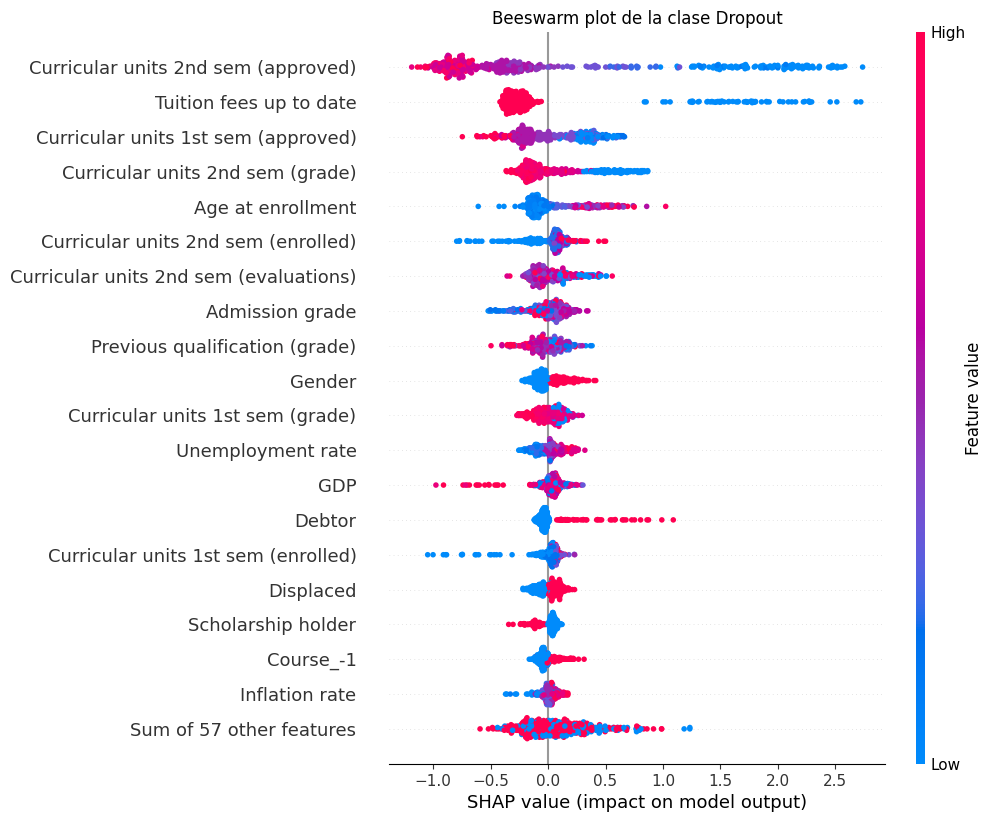

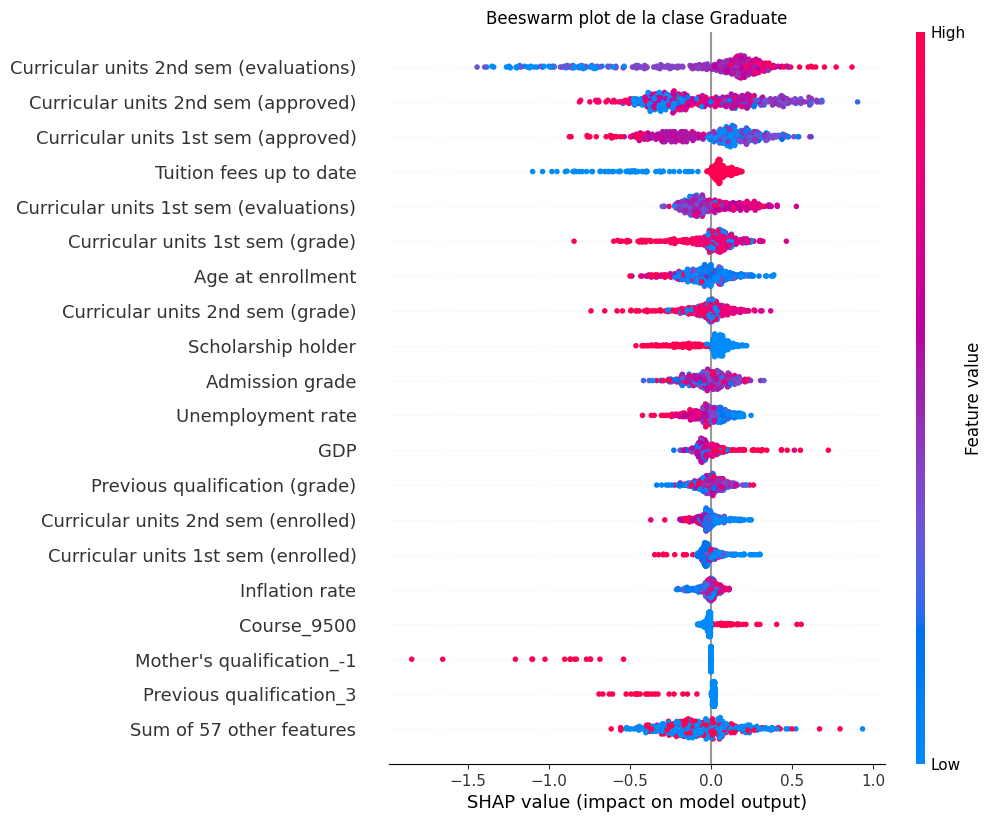

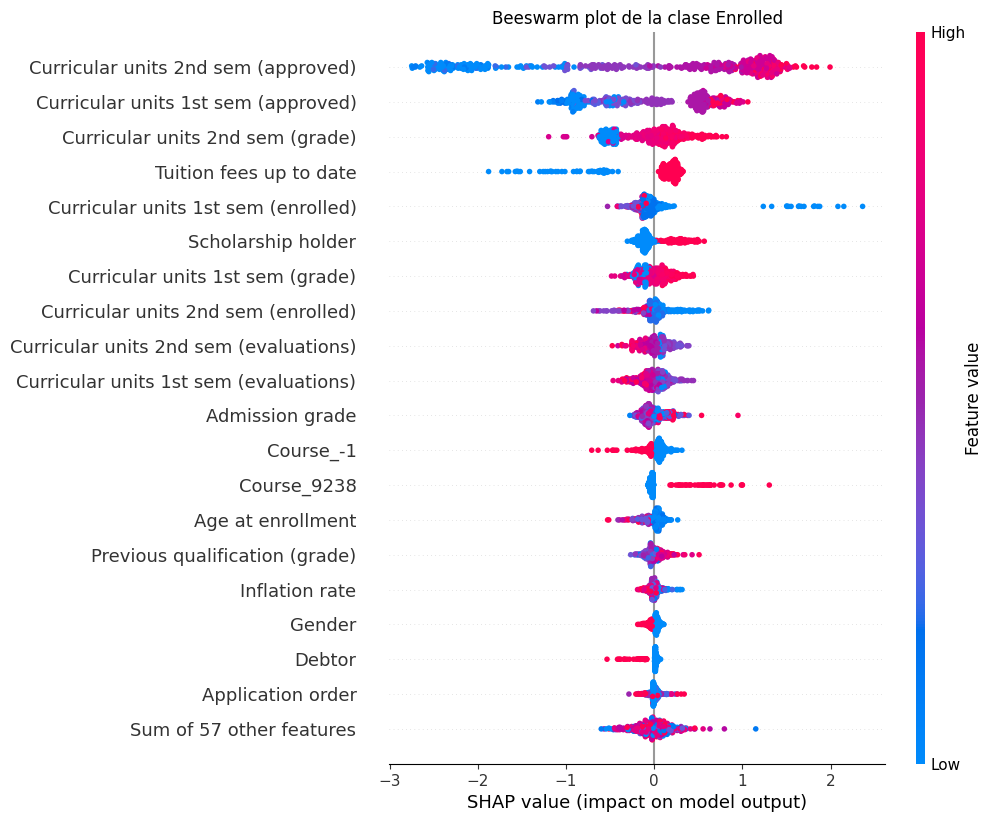

In [44]:
for i, name in enumerate(target_names):
    shap.plots.beeswarm(shap_explanation[:, :, i], max_display=20, show = False)
    plt.title(f"Beeswarm plot de la clase {name}")
    plt.show()

### LIME

Los puntos más interesantes para explicar usando LIME son aquellos en los que el modelo comete errores o está menos seguro de su predicción.

In [45]:
# Obtener el modelo sin preprocesamiento
best_model_final = best_model.named_steps['classifier']

# Preprocesar X_train y X_test
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

In [46]:
# Ajustamos el preprocesador antes de intentar acceder a los nombres de las características
preprocessor = best_model.named_steps['preprocessor']
preprocessor.fit(X_train)  # Ajustar el preprocesador

feature_names = []

# Acceder a los transformers ajustados
for name, transformer, columns in preprocessor.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        feature_names.extend(transformer.get_feature_names_out(columns))
    else:
        # Si no tiene get_feature_names_out, usamos los nombres originales
        feature_names.extend(columns)

# Convertimos a lista de strings
feature_names = list(map(str, feature_names))

#### Ejemplos con baja confianza

Calculamos las probabilidades de predicción, y tomamos aquellos ejemplos de test con menor probabilidad de predicción, puesto que en estos puntos el modelo está menos seguro de su decisión.

In [47]:
probs = best_model.predict_proba(X_test)
confidence = probs.max(axis=1)  # Tomamos la probabilidad más alta de cada predicción
least_confident_idx = np.argsort(confidence)[:3]  # Seleccionamos los 3 ejemplos menos seguros

In [48]:
# LIME explainer
explainer = LimeTabularExplainer(X_train_transformed,
                                 feature_names = feature_names,
                                 class_names=['Dropout', 'Enrolled', 'Graduate'],
                                 mode='classification',
                                 random_state=SEED)

NameError: name 'LimeTabularExplainer' is not defined

In [ ]:
# Obtener la explicación LIME y mostrarla
for i in least_confident_idx:
    exp = explainer.explain_instance(X_test_transformed[i].reshape(1, -1).flatten(), best_model_final.predict_proba, num_features=10)
    exp.show_in_notebook(show_all=False)

#### Ejemplos mal clasificados

In [ ]:
misclassified_idx = np.where(y_pred != y_test)[0][:3]  # Índices de 3 ejemplos mal clasificados

In [ ]:
# Obtener la explicación LIME y mostrarla
for i in least_confident_idx:
    exp = explainer.explain_instance(X_test_transformed[i].reshape(1, -1).flatten(), best_model_final.predict_proba, num_features=10)
    exp.show_in_notebook(show_all=False)

#### Ejemplos cercanos a los bordes de decisión

In [ ]:
decision_function_values = best_model.decision_function(X_test)  # Distancia al hiperplano
border_idx = np.argsort(np.abs(decision_function_values))[:3]  # 3 ejemplos más cercanos al margen

In [ ]:
# Obtener la explicación LIME y mostrarla
for i in least_confident_idx:
    exp = explainer.explain_instance(X_test_transformed[i].reshape(1, -1).flatten(), best_model_final.predict_proba, num_features=10)
    exp.show_in_notebook(show_all=False)

#### Explicación global

In [ ]:
## auxiliary function that gets the weights from explainer
# input: LIME explainer
# output: list of weights of all features

def return_weights(exp):
    exp_list = exp.as_map()[1]
    exp_list = sorted(exp_list, key=lambda x: x[0])
    exp_weight = [x[1] for x in exp_list]
    return exp_weight

In [ ]:
## 1 explainer
#  create local explanations for test points (x point)
#  store them in weight[]

weights = []
for x in X_test_transformed:
    # Obtener explicación para el punto x
    exp = explainer.explain_instance(x.reshape(1, -1).flatten(), best_model_final.predict_proba, num_features=10, labels=[0,1,2])
    # Obtener pesos de la explicación
    exp_weight = return_weights(exp)
    weights.append(exp_weight)

In [ ]:
# Create DataFrame to manipulate the explanations.

lime_weights = pd.DataFrame(weights)
lime_weights.columns = feature_names[:10]
lime_weights.head()

In [ ]:
# AGREGATION 1: ABSOLUTE MEAN

# compute absolute mean
abs_mean = lime_weights.abs().mean(axis=0)

# dataframe with 2 columns: feature name and absolute mean
abs_mean = pd.DataFrame(data={'feature':abs_mean.index, 'abs_mean':abs_mean})
abs_mean = abs_mean.sort_values('abs_mean') # sort from largest to smallest

# SHOW IN A BAR PLOT
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature

plt.barh(y=y_ticks, width=abs_mean.abs_mean)
plt.yticks(ticks=y_ticks, labels=y_labels, size=12)
plt.title('LIME global: aggregation of weights')
plt.ylabel('')
plt.xlabel('Mean of |Weights|', size=15)

## (?) Visualización de las predicciones con PCA

In [ ]:

X_transformed = best_model.named_steps['preprocessor'].fit_transform(X_train)
categorical_features_transformed = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names_trans = list(categorical_features_transformed) + list(numerical_features) + list(binary_features)
print(feature_names_trans)
target_names = ['Dropout', 'Graduate', 'Enrolled']

print('Tipos de las variables:', type(X_transformed), type(feature_names_trans))

['Marital status_-1', 'Marital status_1', 'Marital status_2', 'Application mode_-1', 'Application mode_1', 'Application mode_17', 'Application mode_39', 'Application mode_43', 'Course_-1', 'Course_9070', 'Course_9085', 'Course_9147', 'Course_9238', 'Course_9254', 'Course_9500', 'Course_9670', 'Course_9773', 'Course_9991', "Mother's occupation_-1", "Mother's occupation_2", "Mother's occupation_3", "Mother's occupation_4", "Mother's occupation_5", "Mother's occupation_7", "Mother's occupation_9", "Father's occupation_-1", "Father's occupation_3", "Father's occupation_4", "Father's occupation_5", "Father's occupation_6", "Father's occupation_7", "Father's occupation_8", "Father's occupation_9", "Father's occupation_10", 'Previous qualification_0', 'Previous qualification_1', 'Previous qualification_2', 'Previous qualification_3', "Mother's qualification_-1", "Mother's qualification_0", "Mother's qualification_1", "Mother's qualification_2", "Mother's qualification_3", "Father's qualificat

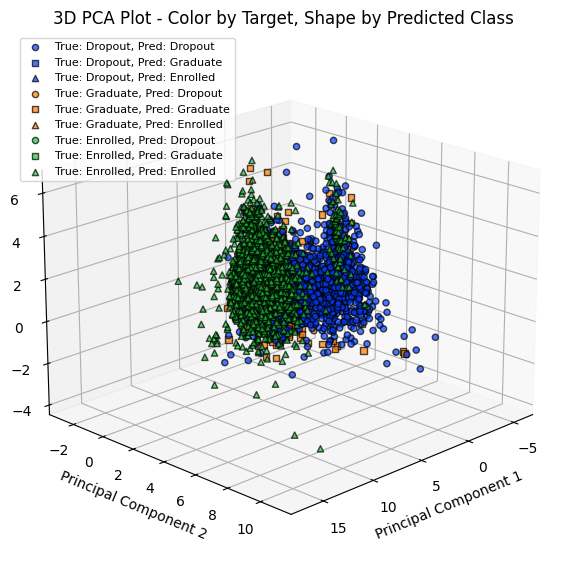

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Apply PCA with 3 components
X_transformed = preprocessor.fit_transform(X)
pca = PCA(n_components=3, random_state=SEED)
X_pca = pca.fit_transform(X_transformed)

# Define colors and markers
palette = sns.color_palette("bright", len(np.unique(y)))
markers = ['o', 's', '^']  # Ensure there are enough markers for predicted classes

# Ensure predictions are correctly assigned
y_pred_all = best_model.predict(X)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i, target in enumerate(np.unique(y)):  # Iterate over true classes
    for j, pred in enumerate(np.unique(y_pred_all)):  # Iterate over predicted classes
        mask = (y == target) & (y_pred_all == pred)  # Correctly apply mask

        if np.any(mask):  # Only plot if there are points in this category
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
                       color=palette[target], marker=markers[pred],
                       label=f'True: {target_names[target]}, Pred: {target_names[pred]}',
                       edgecolors='k', alpha=0.7)

# Labels and title
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA Plot - Color by Target, Shape by Predicted Class")

# Adjust the view angle
ax.view_init(elev=20, azim=45)

# Show legend and plot
plt.legend(loc='best', fontsize=8)
plt.show()


/tmp/ipykernel_18007/2050646644.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best', fontsize=8)


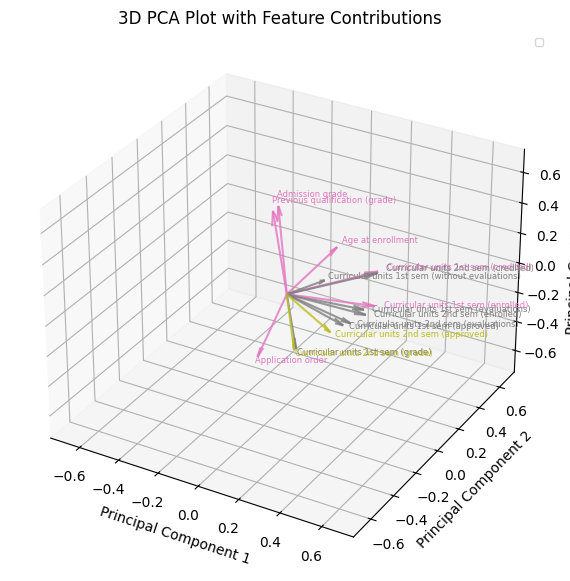

In [ ]:

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


# Definir un mapa de colores
colormap = plt.colormaps['tab10']  # Usamos el colormap actualizado

print(colormap)
# Draw feature contribution arrows in 3D
for i, (feature, vec) in enumerate(zip(feature_names_trans, pca.components_.T)):
    if np.linalg.norm(vec) > 0.25:
        color = colormap(i/len(feature_names_trans))  # Normalizar el índice para obtener colores distintos
        ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color=color, alpha=0.8, arrow_length_ratio=0.15)
        ax.text(vec[0]*1.1, vec[1]*1.1, vec[2]*1.1, feature, fontsize=6, color=color)

# Labels and title
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA Plot with Feature Contributions")

# Set plot limits to keep arrows in bounds
ax.set_xlim([-0.75, 0.75])
ax.set_ylim([-0.75, 0.75])
ax.set_zlim([-0.75, 0.75])

# Show legend and plot
plt.legend(loc='best', fontsize=8)
plt.show()

## Nuestras anotaciones

Tratamiento de variables categóricas con muchas clases. Opciones:

1. Eliminar
2. Threshold: 5% -> clase other
3. Si las clases están en orden se pueden dejar como numérica.



Pasos para terminar el preprocesamiento:

1. Revisar las features: categóricas, binarias y numéricas. OK.
2. Transformar los atributos a su tipo en python. OK
3. Transformar las variables categóricas. OK
4. Escalar las numéricas: decidir el Scaler.
- Normalizar antes de SVM (usar Pipeline). OK
5. Selección de atributos (?).
- Según feature importance (DT).
6. Técnicas de desbalanceo. X
- Si es fácil copiarlo de ML práctica 1, no es necesario·
7. Organizar el código para que el tratamiento sea el mismo en los 3 modelos y se pueda realizar antes de testear o con instancias generadas aleatoriamente.
8. Con One Hot baja mucho el f1 -> hay muchos más atributos

TODO:

- Buscar Decision Tree que implemente partición por atributos categóricos. ?
- Documentación parámetro 'criterion' de Decision Tree.
- Selección de variables para evitar demasiados splits. No hace falta para DT, se probara importancia DT o RF para elresto.
- Mostrar f1 del train para revisar overfitting.
- Organizar el notebook.


- **Explicar el DT**
- Explicación global: ramas/bifurcaciones más importantes. Explicar nodos más puros.
- Explicación global: comentar la importancia de las variables.
- Explicar bifurcaciones: si la instancia está cerca del umbral, se puede hacer una explicación contrafactual o algo.
- Nodos impuros: dan una idea de dónde el modelo es menos preciso.
- Opcional: probar LIME/SHAP.

- **Notebook SVM**
- Obtener el modelo.
- Aplicar LIME/SHAP.

- **Notebook XGBoost**
- Obtener el modelo.
- Aplicar LIME/SHAP.

- Seleccionar instancias a explicar en base a los 3 modelos: instancias donde el modelo sea más estable y donde sea más inestable. Instancias con comportamiento común de los modelos y donde difiera.
- PCA: da información?

Martes: preguntar DT a Juárez.
Lunes: revisar esta lista.
Martes-Viernes: terminar notebook de DT.
Fin de semana: explicabilidad SHAP/Lime de resto de modelos.